# SCDAA COURSEWORK

# Setup <a id='setup'></a>

## Packages

Let's load the some of the packages needed for this workshop. 

In [1]:
import numpy as np
import torch
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal

## Exercise 1  Linear quadratic regulator

#### Exercise 1.1     Solving LQR using from Ricatti ODE

In [2]:
class LQRSolver:
    def __init__(self, H, M, sigma, C, D, R, T, time_grid, device='cpu'):
        # Convert inputs to NumPy arrays (if provided as PyTorch tensors)
        self.H = H.numpy() if isinstance(H, torch.Tensor) else H
        self.M = M.numpy() if isinstance(M, torch.Tensor) else M
        self.sigma = sigma.numpy() if isinstance(sigma, torch.Tensor) else sigma
        self.C = C.numpy() if isinstance(C, torch.Tensor) else C
        self.D = D.numpy() if isinstance(D, torch.Tensor) else D
        self.R = R.numpy() if isinstance(R, torch.Tensor) else R
        self.T = T
        self.device = device

        # Ensure the time grid is sorted in ascending order
        time_grid_np = time_grid.numpy() if isinstance(time_grid, torch.Tensor) else np.array(time_grid)
        self.time_grid_np = np.sort(time_grid_np)

        # Solve the Riccati ODE backward in time (from T to 0) and store results in ascending order
        self.solve_riccati_ode()

        # Precompute tensors to accelerate value and control computations
        self.S_tensor = torch.stack([torch.tensor(S, dtype=torch.float32) for S in self.S_array]).to(device)  # (N_t, 2, 2)
        self.z_tensor = torch.tensor(self.z_array, dtype=torch.float32).to(device)  # (N_t,)
        self.D_tensor = torch.tensor(self.D, dtype=torch.float32).to(device)
        self.D_inv_tensor = torch.inverse(self.D_tensor).to(device)
        self.M_tensor = torch.tensor(self.M, dtype=torch.float32).to(device)

    def solve_riccati_ode(self):
        def ode_func(t, y):
            # y = [S11, S12, S22, z]
            S11, S12, S22, z = y
            S = np.array([[S11, S12], [S12, S22]])
            D_inv = np.linalg.inv(self.D)
            MD_inv_MT = self.M @ D_inv @ self.M.T
            dS_dt = S @ MD_inv_MT @ S - self.H.T @ S - S @ self.H - self.C
            ds11, ds12, ds22 = dS_dt[0, 0], dS_dt[0, 1], dS_dt[1, 1]
            sigma_sigma_T = self.sigma @ self.sigma.T
            dz_dt = -np.trace(sigma_sigma_T @ S)
            return [ds11, ds12, ds22, dz_dt]

        # Terminal condition at t = T
        S_T = self.R
        y0 = [S_T[0, 0], S_T[0, 1], S_T[1, 1], 0.0]

        # Solve the terminal value problem backward in time from T to 0
        sol = solve_ivp(ode_func, [self.T, 0.0], y0, t_eval=self.time_grid_np[::-1], method='RK45')
        if not sol.success:
            raise RuntimeError("ODE solver failed: " + sol.message)

        # Reverse time and solution arrays to match ascending time order
        sol_t_rev = sol.t[::-1]
        y_rev = sol.y[:, ::-1]
        self.S_array = []
        self.z_array = []
        for i in range(len(sol_t_rev)):
            S = np.array([[y_rev[0, i], y_rev[1, i]], [y_rev[1, i], y_rev[2, i]]])
            self.S_array.append(S)
            self.z_array.append(y_rev[3, i])
        # S_array and z_array now match self.time_grid_np in ascending order

    def compute_value(self, t_tensor, x_tensor):
        """
        Evaluate the value function v(t, x) = x^T S(t) x + z(t)
        Inputs:
            t_tensor: Tensor of shape (N_t_eval,) — evaluation times
            x_tensor: Tensor of shape (N_x, 2) — input state vectors
        Output:
            Tensor of shape (N_t_eval, N_x) — value function values
        """
        # 1) Get indices of the closest time points for interpolation
        t_np = t_tensor.cpu().numpy()
        indices = [max(np.searchsorted(self.time_grid_np, t, side='right') - 1, 0) for t in t_np]
        indices = torch.tensor(indices, device=self.device)

        selected_S = self.S_tensor[indices]  # (N_t_eval, 2, 2)
        selected_z = self.z_tensor[indices]  # (N_t_eval,)

        # 2) Compute x^T S x
        S_exp = selected_S.unsqueeze(1)       # (N_t_eval, 1, 2, 2)
        x_exp = x_tensor.unsqueeze(0).unsqueeze(-1)  # (1, N_x, 2, 1)
        Sx = torch.matmul(S_exp, x_exp)       # (N_t_eval, N_x, 2, 1)

        xT = x_exp.transpose(-2, -1)          # (1, N_x, 1, 2)
        xSx = torch.matmul(xT, Sx)            # (N_t_eval, N_x, 1, 1)
        xSx = xSx.squeeze(-1).squeeze(-1)     # (N_t_eval, N_x)

        # 3) Add z(t)
        z_exp = selected_z.unsqueeze(1)       # (N_t_eval, 1)
        v = xSx + z_exp                       # (N_t_eval, N_x)

        return v

    def compute_control(self, t_tensor, x_tensor):
        """
        Evaluate the optimal control a(t, x) = -D^{-1} M^T S(t) x
        Inputs:
            t_tensor: Tensor of shape (N_t_eval,) — evaluation times
            x_tensor: Tensor of shape (N_x, 2) — input state vectors
        Output:
            Tensor of shape (N_t_eval, N_x, 2) — optimal controls
        """
        # 1) Get indices of the closest time points for interpolation
        t_np = t_tensor.cpu().numpy()
        indices = [max(np.searchsorted(self.time_grid_np, t, side='right') - 1, 0) for t in t_np]
        indices = torch.tensor(indices, device=self.device)

        selected_S = self.S_tensor[indices]  # (N_t_eval, 2, 2)

        # 2) Compute term = (D^{-1} M^T) * S(t)
        const_part = torch.matmul(self.D_inv_tensor, self.M_tensor.t())  # (2, 2)
        const_part_exp = const_part.unsqueeze(0)                         # (1, 2, 2)
        term = torch.matmul(const_part_exp, selected_S)                  # (N_t_eval, 2, 2)

        # 3) Multiply with x: x shape = (N_x, 2) → (1, N_x, 2, 1)
        x_exp = x_tensor.unsqueeze(0).unsqueeze(-1)                      # (1, N_x, 2, 1)
        term_exp = term.unsqueeze(1)                                     # (N_t_eval, 1, 2, 2)

        a = -torch.matmul(term_exp, x_exp).squeeze(-1)                   # (N_t_eval, N_x, 2)

        return a


In [3]:
if __name__ == "__main__":
    # ========================== Define model parameters ==========================
    # Parameters are set according to the problem description
    H = torch.tensor([[1.0, 1.0],[0.0, 1.0]], dtype=torch.float32) * 0.5
    M = torch.tensor([[1.0, 1.0],[0.0, 1.0]], dtype=torch.float32)
    sigma = torch.eye(2, dtype=torch.float32) * 0.5
    C = torch.tensor([[1.0, 0.1],[0.1, 1.0]], dtype=torch.float32)
    D = torch.tensor([[1.0, 0.1],[0.1, 1.0]], dtype=torch.float32) * 0.1
    R = torch.tensor([[1.0, 0.3],[0.3, 1.0]], dtype=torch.float32) * 10.0
    T = 0.5
    time_grid = np.linspace(0, T, 10000)

    # ========================== Initialize LQRSolver ==========================
    solver = LQRSolver(
        H=H, M=M, sigma=sigma, C=C, D=D, R=R, T=T,
        time_grid=time_grid, device="cpu"
    )

    # ========================== Define evaluation points ==========================
    t_test = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32)
    x_test = torch.tensor([
        [1.0, 1.0], 
        [2.0, 2.0], 
        [-1.0, -1.0]
    ], dtype=torch.float32)

    # ========================== Compute value function v(t, x) ==========================
    value = solver.compute_value(t_test, x_test)
    # Output shape: (N_t_eval, N_x)
    print("\nValue function (v(t, x)):")
    print(value.detach().numpy())

    # ========================== Compute optimal control a(t, x) ==========================
    control = solver.compute_control(t_test, x_test)
    # Output shape: (N_t_eval, N_x, 2)
    print("\nOptimal control (a(t, x)):")
    print(control.detach().numpy())



Value function (v(t, x)):
[[0.7729942 2.414532  0.7729942]
 [0.7818313 2.5295322 0.7818313]
 [0.8512579 2.9034116 0.8512579]]

Optimal control (a(t, x)):
[[[ -1.198806   -5.351912 ]
  [ -2.397612  -10.703824 ]
  [  1.198806    5.351912 ]]

 [[ -1.0985146  -5.7158184]
  [ -2.197029  -11.431637 ]
  [  1.0985146   5.7158184]]

 [[ -1.0238967  -6.7381234]
  [ -2.0477934 -13.476247 ]
  [  1.0238967   6.7381234]]]


#### Exercise 1.2  LQR MC checks

Using device: cpu

Testing for initial state x0 = [1. 1.]

Using explicit scheme:

Testing convergence w.r.t. time discretization:
Exact value from solver: 0.782733
N = 2, MC estimate = 3.592328, Error = 2.809595
N = 4, MC estimate = 1.559814, Error = 0.777081
N = 8, MC estimate = 1.125306, Error = 0.342573
N = 16, MC estimate = 0.941051, Error = 0.158318
N = 32, MC estimate = 0.857762, Error = 0.075029
N = 64, MC estimate = 0.815240, Error = 0.032507
N = 128, MC estimate = 0.797760, Error = 0.015027
N = 256, MC estimate = 0.795764, Error = 0.013031
N = 512, MC estimate = 0.787283, Error = 0.004550
N = 1024, MC estimate = 0.786352, Error = 0.003619
N = 2048, MC estimate = 0.783541, Error = 0.000808


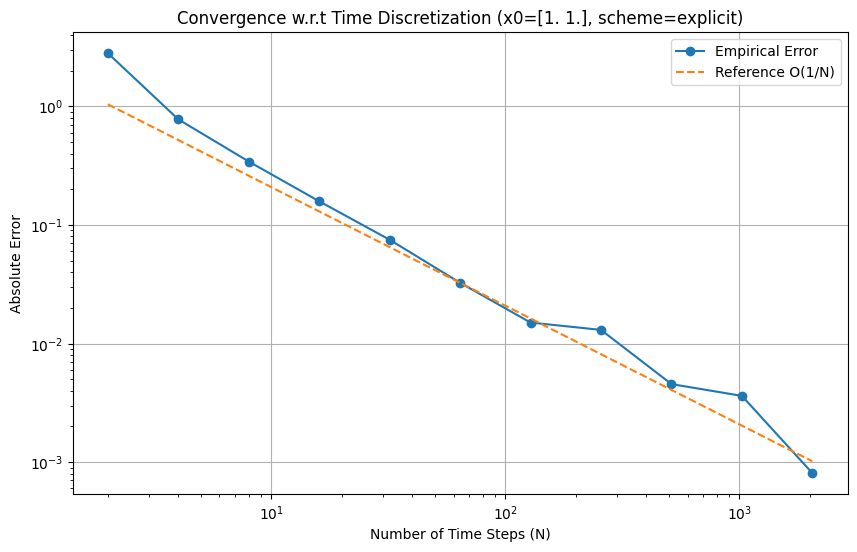


Testing convergence w.r.t. Monte Carlo samples:
Exact value from solver: 0.782733
M = 2, MC estimate = 0.868025, Error = 0.085292
M = 8, MC estimate = 0.802047, Error = 0.019314
M = 32, MC estimate = 0.744567, Error = 0.038166
M = 128, MC estimate = 0.773933, Error = 0.008800
M = 512, MC estimate = 0.775871, Error = 0.006862
M = 2048, MC estimate = 0.785541, Error = 0.002807


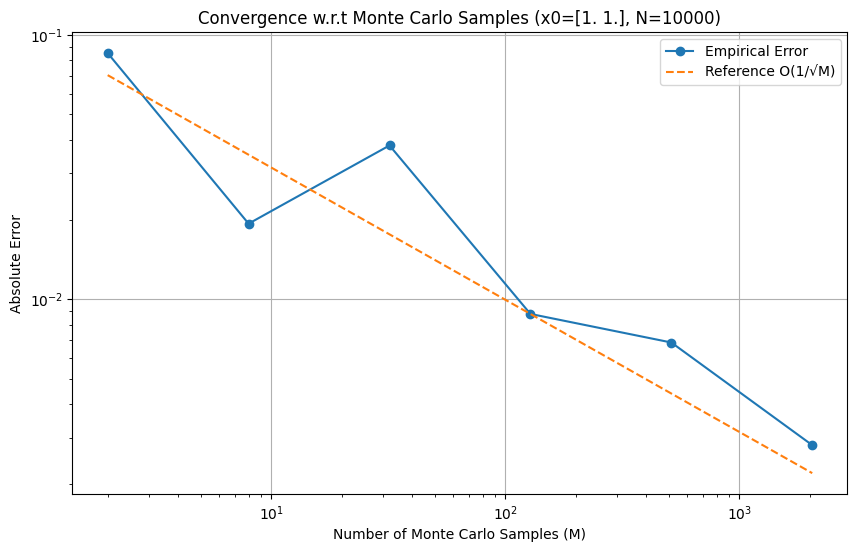


Analysis:
Expected convergence rate for time discretization: O(Δt) → slope = -1.0
Expected convergence rate for Monte Carlo: O(1/√M) → slope = -0.5
Empirical convergence rate for time discretization: -1.0730
Empirical convergence rate for Monte Carlo: -0.4460

Conclusion:
Time discretization rate (-1.0730) is close to theoretical (-1.0)
Monte Carlo rate (-0.4460) is close to theoretical (-0.5)

----------------------------------------

Using implicit scheme:

Testing convergence w.r.t. time discretization:
Exact value from solver: 0.782733
N = 2, MC estimate = 10.403213, Error = 9.620479
N = 4, MC estimate = 1.674795, Error = 0.892062
N = 8, MC estimate = 1.133395, Error = 0.350662
N = 16, MC estimate = 0.936734, Error = 0.154001
N = 32, MC estimate = 0.853775, Error = 0.071042
N = 64, MC estimate = 0.810448, Error = 0.027715
N = 128, MC estimate = 0.802574, Error = 0.019841
N = 256, MC estimate = 0.790564, Error = 0.007831
N = 512, MC estimate = 0.789157, Error = 0.006424
N = 1024, M

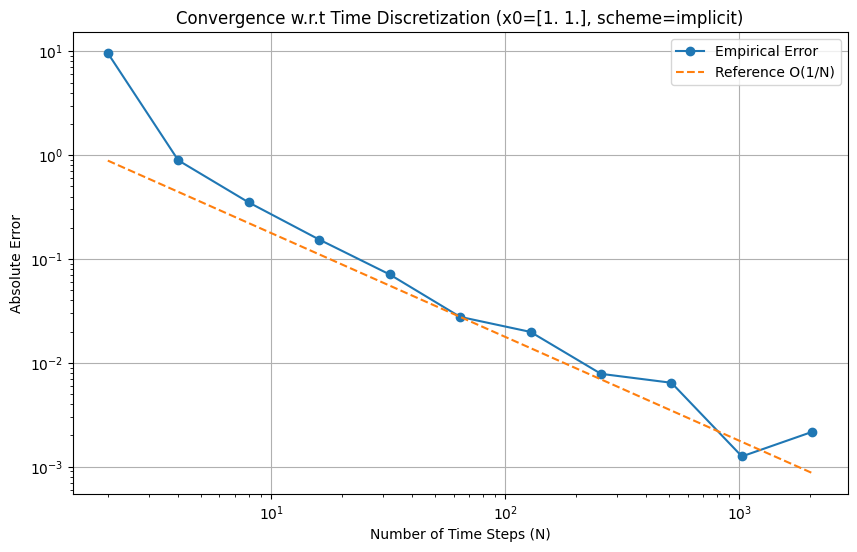


Testing convergence w.r.t. Monte Carlo samples:
Exact value from solver: 0.782733
M = 2, MC estimate = 0.713287, Error = 0.069446
M = 8, MC estimate = 0.867801, Error = 0.085068
M = 32, MC estimate = 0.717996, Error = 0.064737
M = 128, MC estimate = 0.806308, Error = 0.023575
M = 512, MC estimate = 0.753166, Error = 0.029567
M = 2048, MC estimate = 0.790755, Error = 0.008022


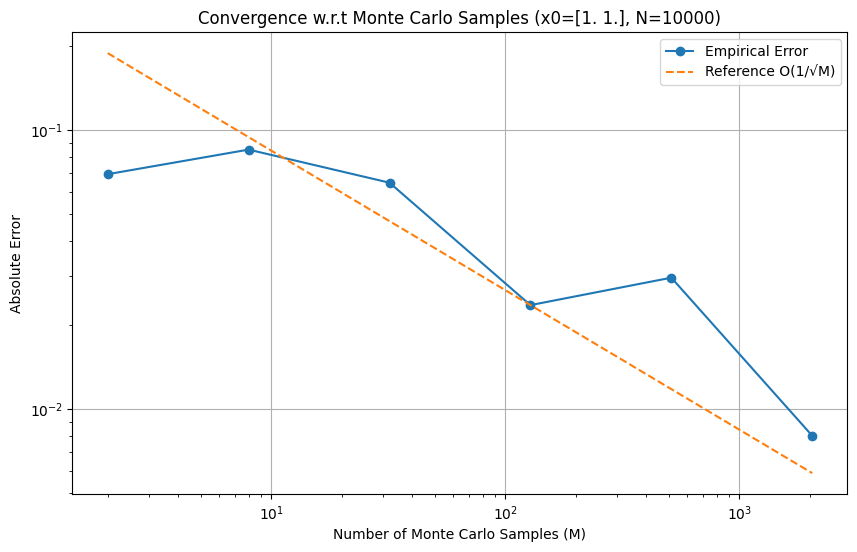


Analysis:
Expected convergence rate for time discretization: O(Δt) → slope = -1.0
Expected convergence rate for Monte Carlo: O(1/√M) → slope = -0.5
Empirical convergence rate for time discretization: -1.1475
Empirical convergence rate for Monte Carlo: -0.3086

Conclusion:
Time discretization rate (-1.1475) is close to theoretical (-1.0)
Monte Carlo rate (-0.3086) is close to theoretical (-0.5)

----------------------------------------

Testing for initial state x0 = [2. 2.]

Using explicit scheme:

Testing convergence w.r.t. time discretization:
Exact value from solver: 2.382238
N = 2, MC estimate = 9.569489, Error = 7.187250
N = 4, MC estimate = 3.857910, Error = 1.475672
N = 8, MC estimate = 3.010930, Error = 0.628691
N = 16, MC estimate = 2.668973, Error = 0.286735
N = 32, MC estimate = 2.516403, Error = 0.134165
N = 64, MC estimate = 2.443635, Error = 0.061396
N = 128, MC estimate = 2.409639, Error = 0.027401
N = 256, MC estimate = 2.398158, Error = 0.015920
N = 512, MC estimate =

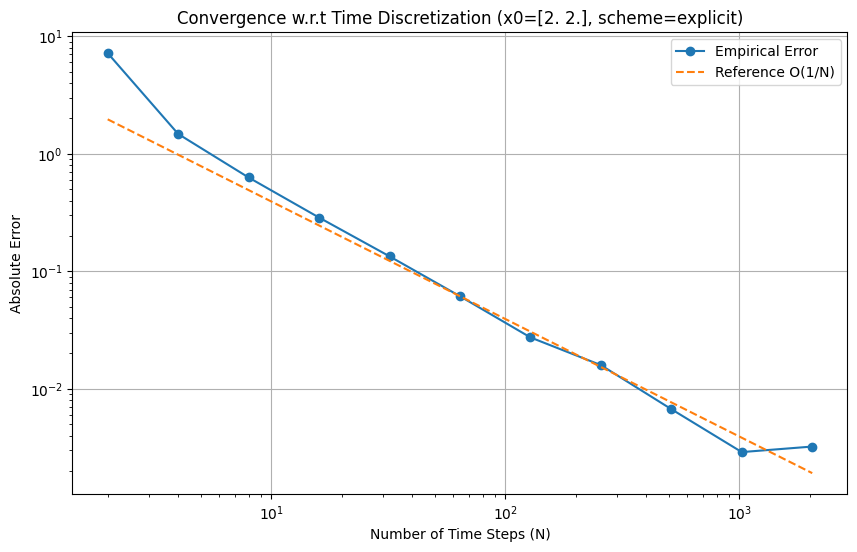


Testing convergence w.r.t. Monte Carlo samples:
Exact value from solver: 2.382238
M = 2, MC estimate = 2.809011, Error = 0.426772
M = 8, MC estimate = 2.314911, Error = 0.067327
M = 32, MC estimate = 2.382482, Error = 0.000244
M = 128, MC estimate = 2.409222, Error = 0.026984
M = 512, MC estimate = 2.392203, Error = 0.009964
M = 2048, MC estimate = 2.378170, Error = 0.004069


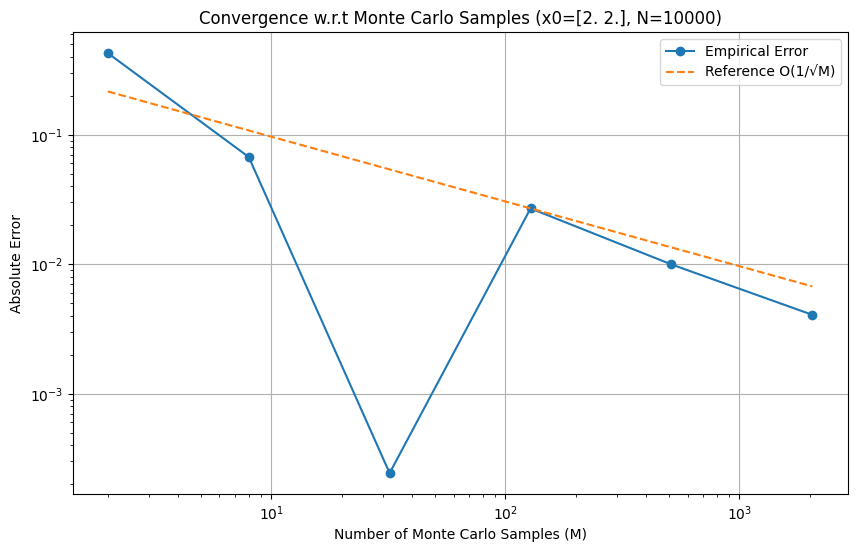


Analysis:
Expected convergence rate for time discretization: O(Δt) → slope = -1.0
Expected convergence rate for Monte Carlo: O(1/√M) → slope = -0.5
Empirical convergence rate for time discretization: -1.1077
Empirical convergence rate for Monte Carlo: -0.5006

Conclusion:
Time discretization rate (-1.1077) is close to theoretical (-1.0)
Monte Carlo rate (-0.5006) is close to theoretical (-0.5)

----------------------------------------

Using implicit scheme:

Testing convergence w.r.t. time discretization:
Exact value from solver: 2.382238
N = 2, MC estimate = 33.770271, Error = 31.388033
N = 4, MC estimate = 3.852232, Error = 1.469994
N = 8, MC estimate = 2.957735, Error = 0.575497
N = 16, MC estimate = 2.635572, Error = 0.253334
N = 32, MC estimate = 2.494429, Error = 0.112190
N = 64, MC estimate = 2.434843, Error = 0.052605
N = 128, MC estimate = 2.409058, Error = 0.026820
N = 256, MC estimate = 2.389709, Error = 0.007471
N = 512, MC estimate = 2.385864, Error = 0.003626
N = 1024, 

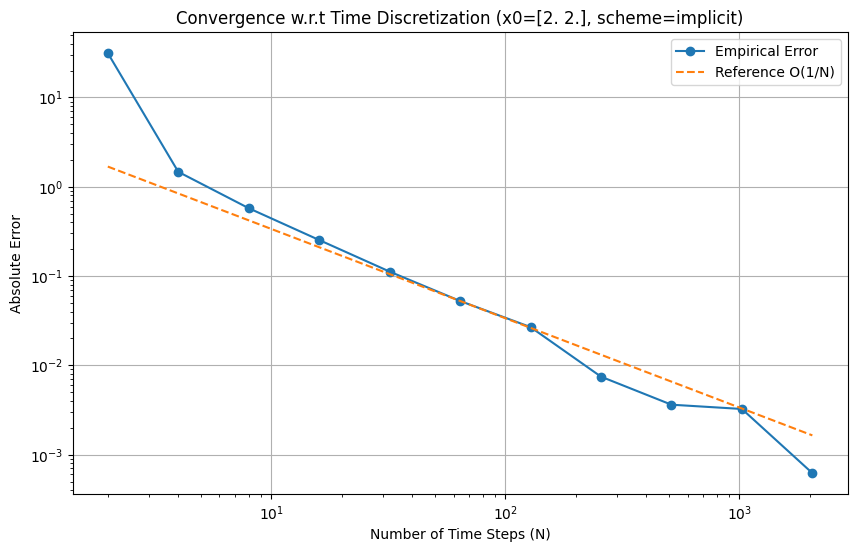


Testing convergence w.r.t. Monte Carlo samples:
Exact value from solver: 2.382238
M = 2, MC estimate = 2.505415, Error = 0.123177
M = 8, MC estimate = 2.361160, Error = 0.021079
M = 32, MC estimate = 2.423735, Error = 0.041497
M = 128, MC estimate = 2.397923, Error = 0.015684
M = 512, MC estimate = 2.362002, Error = 0.020236
M = 2048, MC estimate = 2.382876, Error = 0.000638


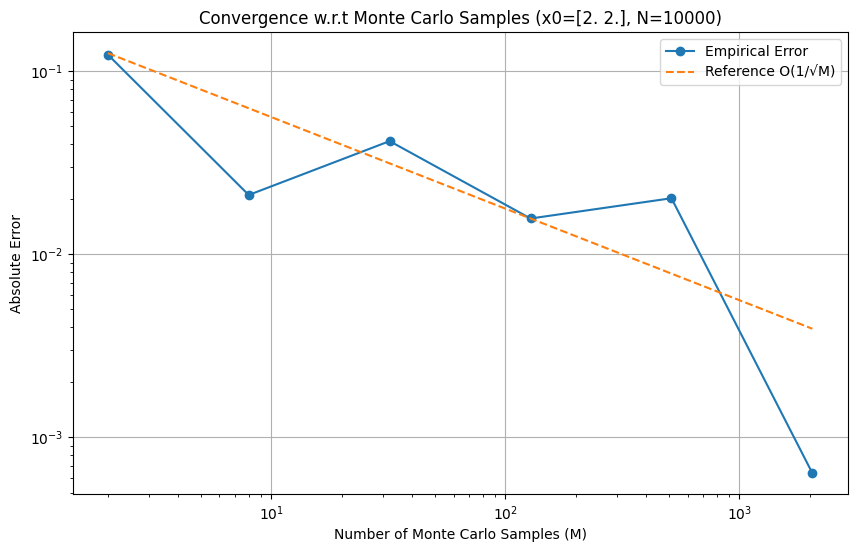


Analysis:
Expected convergence rate for time discretization: O(Δt) → slope = -1.0
Expected convergence rate for Monte Carlo: O(1/√M) → slope = -0.5
Empirical convergence rate for time discretization: -1.3416
Empirical convergence rate for Monte Carlo: -0.5649

Conclusion:
Time discretization rate (-1.3416) is different from theoretical (-1.0)
Monte Carlo rate (-0.5649) is close to theoretical (-0.5)

----------------------------------------

Exercise 1.2 completed successfully!


In [4]:
def monte_carlo_simulation(solver, x0, t0, T, N, M, scheme='explicit', device='cpu'):
    """
    Run a Monte Carlo simulation to approximate the value function
    
    Parameters:
    - solver: LQRSolver object
    - x0: Initial state tensor of shape (2,)
    - t0: Initial time
    - T: Terminal time
    - N: Number of time steps
    - M: Number of Monte Carlo samples
    - scheme: 'explicit' or 'implicit' discretization scheme
    - device: 'cpu' or 'cuda'
    
    Returns:
    - Estimated value function at (t0, x0)
    """
    # Convert to PyTorch tensors
    H = torch.tensor(solver.H, device=device)
    M_mat = torch.tensor(solver.M, device=device)
    sigma = torch.tensor(solver.sigma, device=device)
    C = torch.tensor(solver.C, device=device)
    D = torch.tensor(solver.D, device=device)
    R = torch.tensor(solver.R, device=device)
    
    dt = (T - t0) / N
    
    # Initialize state for all M samples
    X = x0.repeat(M, 1).to(device)  # Shape: (M, 2)
    total_cost = torch.zeros(M, device=device)
    
    # Create time tensor for the entire simulation
    time_points = torch.linspace(t0, T-dt, N, device=device)
    
    for n in range(N):
        t = time_points[n]
        t_tensor = t.unsqueeze(0)
        
        # Compute optimal control using LQRSolver's optimal control function
        # This is precisely using the result from Exercise 1.1
        a = solver.compute_control(t_tensor, X).squeeze(0)  # Shape: (M, 2)
        
        # Running cost for this step
        x_cost = torch.sum(X * torch.matmul(C, X.T).T, dim=1)  # X^T C X
        a_cost = torch.sum(a * torch.matmul(D, a.T).T, dim=1)  # a^T D a
        total_cost += (x_cost + a_cost) * dt
        
        # Brownian increment
        dW = torch.randn(M, 2, device=device) * torch.sqrt(torch.tensor(dt, device=device))
        
        if scheme == 'explicit':
            # Explicit Euler-Maruyama scheme as described in Exercise 1.2
            # dXs = [HXs + Ma(s, Xs)]ds + σdWs
            drift = torch.matmul(H, X.T).T + torch.matmul(M_mat, a.T).T
            X = X + drift * dt + torch.matmul(sigma, dW.T).T
        else:
            # Implicit scheme as described in Exercise 1.2
            # Requires solving a linear system at each step
            I = torch.eye(2, device=device)
            A = I - H * dt
            b = X + torch.matmul(M_mat, a.T).T * dt + torch.matmul(sigma, dW.T).T
            
            # This is a batch solve for all M samples
            X = torch.linalg.solve(A.repeat(M, 1, 1), b)
    
    # Terminal cost
    terminal_cost = torch.sum(X * torch.matmul(R, X.T).T, dim=1)  # X^T R X
    total_cost += terminal_cost
    
    return total_cost.mean().item()

def test_time_discretization(solver, x0, t0, T, M=10000, scheme='explicit', device='cpu'):
    """
    Test convergence with respect to time discretization
    
    Parameters:
    - solver: LQRSolver object
    - x0: Initial state tensor
    - t0: Initial time
    - T: Terminal time
    - M: Number of Monte Carlo samples to use
    - scheme: 'explicit' or 'implicit' discretization scheme
    - device: 'cpu' or 'cuda'
    
    Returns:
    - Ns: Array of time step counts
    - errors: Array of corresponding errors
    """
    # Compute exact value using the solver's value function
    # This uses the analytical solution from Exercise 1.1
    t_tensor = torch.tensor([t0], device=device)
    x_tensor = x0.unsqueeze(0)
    exact_value = solver.compute_value(t_tensor, x_tensor).item()
    print(f"Exact value from solver: {exact_value:.6f}")
    
    # Test different numbers of time steps
    Ns = [2**i for i in range(1, 12)]  # 2, 4, 8, ..., 2048
    errors = []
    
    for N in Ns:
        # Run Monte Carlo with optimal control from Exercise 1.1
        mc_value = monte_carlo_simulation(solver, x0, t0, T, N, M, scheme=scheme, device=device)
        error = abs(exact_value - mc_value)
        errors.append(error)
        print(f"N = {N}, MC estimate = {mc_value:.6f}, Error = {error:.6f}")
    
    # Plot error vs. number of time steps (log-log scale)
    plt.figure(figsize=(10, 6))
    plt.loglog(Ns, errors, 'o-', label='Empirical Error')
    
    # Add reference line with slope -1 (expected first-order convergence for Euler-Maruyama)
    ref_x = np.array([min(Ns), max(Ns)])
    
    # Find a middle point to anchor the reference line for better visualization
    idx = len(Ns) // 2
    ref_const = errors[idx] * Ns[idx]
    ref_y = ref_const / ref_x
    
    plt.loglog(ref_x, ref_y, '--', label='Reference O(1/N)')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Absolute Error')
    plt.title(f'Convergence w.r.t Time Discretization (x0={x0.numpy()}, scheme={scheme})')
    plt.grid(True)
    plt.legend()
    # plt.savefig(f'time_convergence_x0_{x0[0]}_{x0[1]}_{scheme}.png')
    plt.show()
    
    return Ns, errors

def test_mc_samples(solver, x0, t0, T, N=10000, scheme='explicit', device='cpu'):
    """
    Test convergence with respect to number of Monte Carlo samples
    
    Parameters:
    - solver: LQRSolver object
    - x0: Initial state tensor
    - t0: Initial time
    - T: Terminal time
    - N: Number of time steps to use
    - scheme: 'explicit' or 'implicit' discretization scheme
    - device: 'cpu' or 'cuda'
    
    Returns:
    - Ms: Array of sample counts
    - errors: Array of corresponding errors
    """
    # Compute exact value using the solver's value function
    # This uses the analytical solution from Exercise 1.1
    t_tensor = torch.tensor([t0], device=device)
    x_tensor = x0.unsqueeze(0)
    exact_value = solver.compute_value(t_tensor, x_tensor).item()
    print(f"Exact value from solver: {exact_value:.6f}")
    
    # Test different numbers of Monte Carlo samples as specified in exercise
    Ms = [2 * (4**i) for i in range(6)]  # 2, 8, 32, 128, 512, 2048
    errors = []
    
    for M in Ms:
        # Run Monte Carlo with optimal control from Exercise 1.1
        mc_value = monte_carlo_simulation(solver, x0, t0, T, N, M, scheme=scheme, device=device)
        error = abs(exact_value - mc_value)
        errors.append(error)
        print(f"M = {M}, MC estimate = {mc_value:.6f}, Error = {error:.6f}")
    
    # Plot error vs. number of samples (log-log scale)
    plt.figure(figsize=(10, 6))
    plt.loglog(Ms, errors, 'o-', label='Empirical Error')
    
    # Add reference line with slope -0.5 (expected Monte Carlo convergence rate)
    ref_x = np.array([min(Ms), max(Ms)])
    
    # Find a middle point to anchor the reference line for better visualization
    idx = len(Ms) // 2
    ref_const = errors[idx] * np.sqrt(Ms[idx])
    ref_y = ref_const / np.sqrt(ref_x)
    
    plt.loglog(ref_x, ref_y, '--', label='Reference O(1/√M)')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Absolute Error')
    plt.title(f'Convergence w.r.t Monte Carlo Samples (x0={x0.numpy()}, N={N})')
    plt.grid(True)
    plt.legend()
    # plt.savefig(f'mc_convergence_x0_{x0[0]}_{x0[1]}_N{N}.png')
    plt.show()
    
    return Ms, errors

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Problem parameters exactly as in Figure 1 of the assignment
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
    T = 0.5  # Final time as specified in the exercise
    
    # Create a fine time grid for accurate Ricatti ODE solution
    time_grid = np.linspace(0, T, 10000)
    
    # Device configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Initialize the solver with your LQRSolver from Exercise 1.1
    solver = LQRSolver(
        H=H,
        M=M,
        sigma=sigma,
        C=C,
        D=D,
        R=R,
        T=T,
        time_grid=time_grid,
        device=device
    )
    
    # Test cases as specified in the exercise
    test_points = [
        torch.tensor([1.0, 1.0], device=device),  # x = (1, 1)
        torch.tensor([2.0, 2.0], device=device)   # x = (2, 2)
    ]
    
    # We'll test both explicit and implicit schemes
    schemes = ['explicit', 'implicit']
    
    for x0 in test_points:
        print(f"\n{'='*50}")
        print(f"Testing for initial state x0 = {x0.cpu().numpy()}")
        print(f"{'='*50}")
        
        for scheme in schemes:
            print(f"\nUsing {scheme} scheme:")
            
            # Test 1: Convergence w.r.t. time discretization
            # Keep Monte Carlo samples large enough (10000) to minimize sampling error
            print("\nTesting convergence w.r.t. time discretization:")
            Ns, time_errors = test_time_discretization(
                solver, x0, 0.0, T, M=10000, scheme=scheme, device=device
            )
            
            # Test 2: Convergence w.r.t. Monte Carlo samples
            # Keep time steps large enough (10000) to minimize discretization error
            print("\nTesting convergence w.r.t. Monte Carlo samples:")
            Ms, mc_errors = test_mc_samples(
                solver, x0, 0.0, T, N=10000, scheme=scheme, device=device
            )
            
            # Analysis of results
            print("\nAnalysis:")
            print(f"Expected convergence rate for time discretization: O(Δt) → slope = -1.0")
            print(f"Expected convergence rate for Monte Carlo: O(1/√M) → slope = -0.5")
            
            # Calculate empirical convergence rates using linear regression on log-log data
            if len(Ns) > 1 and len(time_errors) > 1:
                time_rate = np.polyfit(np.log(Ns), np.log(time_errors), 1)[0]
                print(f"Empirical convergence rate for time discretization: {time_rate:.4f}")
            
            if len(Ms) > 1 and len(mc_errors) > 1:
                mc_rate = np.polyfit(np.log(Ms), np.log(mc_errors), 1)[0]
                print(f"Empirical convergence rate for Monte Carlo: {mc_rate:.4f}")
            
            # Compare with theoretical rates
            print("\nConclusion:")
            if len(Ns) > 1 and len(time_errors) > 1:
                time_match = "close to" if abs(time_rate + 1.0) < 0.3 else "different from"
                print(f"Time discretization rate ({time_rate:.4f}) is {time_match} theoretical (-1.0)")
            
            if len(Ms) > 1 and len(mc_errors) > 1:
                mc_match = "close to" if abs(mc_rate + 0.5) < 0.2 else "different from"
                print(f"Monte Carlo rate ({mc_rate:.4f}) is {mc_match} theoretical (-0.5)")
            
            print(f"\n{'-'*40}")
    
    print("\nExercise 1.2 completed successfully!")

if __name__ == "__main__":
    main()

## Exercise 2   Soft linear quadratic regulator

#### Exercise 2.1  Solving soft LQR

In [5]:
class SoftLQRSolver:
    def __init__(self, H, M, sigma, C, D, R, T, time_grid, tau, gamma, device='cpu'):
        # Convert all inputs to NumPy arrays if they are provided as PyTorch tensors
        self.H = H.numpy() if isinstance(H, torch.Tensor) else H
        self.M = M.numpy() if isinstance(M, torch.Tensor) else M
        self.sigma = sigma.numpy() if isinstance(sigma, torch.Tensor) else sigma
        self.C = C.numpy() if isinstance(C, torch.Tensor) else C
        self.D = D.numpy() if isinstance(D, torch.Tensor) else D
        self.R = R.numpy() if isinstance(R, torch.Tensor) else R
        self.T = T
        self.tau = tau
        self.gamma = gamma
        self.device = device

        # Sort the time grid in ascending order
        time_grid_np = time_grid.numpy() if isinstance(time_grid, torch.Tensor) else np.array(time_grid)
        self.time_grid_np = np.sort(time_grid_np)

        # Solve the soft Riccati ODE and store solutions for S(t) and b(t)
        self.solve_riccati_ode()

        # Convert solutions to PyTorch tensors for fast computation
        self.S_tensor = torch.stack([torch.tensor(S, dtype=torch.float32) for S in self.S_array]).to(device)
        self.b_tensor = torch.tensor(self.b_array, dtype=torch.float32).to(device)
        self.M_tensor = torch.tensor(self.M, dtype=torch.float32).to(device)
        self.D_tensor = torch.tensor(self.D, dtype=torch.float32).to(device)
        self.D_inv_tensor = torch.inverse(self.D_tensor).to(device)

    def solve_riccati_ode(self):
        d = self.H.shape[0]
        def ode(t, y):
            # y = [S11, S12, S22, b], reconstruct symmetric matrix S
            S = np.array([[y[0], y[1]], [y[1], y[2]]])
            D_reg = self.D + (self.tau / (2 * self.gamma**2)) * np.eye(d)
            Sigma = np.linalg.inv(D_reg)
            dS_dt = -S @ self.H - self.H.T @ S - self.C + S @ self.M @ Sigma @ self.M.T @ S
            db_dt = -np.trace(self.sigma @ self.sigma.T @ S) + self.tau * np.log(
                (self.tau / self.gamma**2)**d * np.linalg.det(D_reg)) / 2
            return [dS_dt[0,0], dS_dt[0,1], dS_dt[1,1], db_dt]

        # Initial condition at terminal time T: S(T) = R, b(T) = 0
        y0 = [self.R[0,0], self.R[0,1], self.R[1,1], 0.0]

        # Integrate ODE backward in time from T to 0
        sol = solve_ivp(ode, [self.T, 0], y0, t_eval=self.time_grid_np[::-1], method='RK45')

        # Reverse solution to match ascending time grid
        y_rev = sol.y[:, ::-1]
        self.S_array, self.b_array = [], []
        for i in range(len(self.time_grid_np)):
            S = np.array([[y_rev[0, i], y_rev[1, i]], [y_rev[1, i], y_rev[2, i]]])
            self.S_array.append(S)
            self.b_array.append(y_rev[3, i])

    def compute_value(self, t_tensor, x_tensor):
        # Given batch of (t, x), compute v(t, x) = x^T S(t) x + b(t)
        t_np = t_tensor.cpu().numpy()
        indices = [max(np.searchsorted(self.time_grid_np, t, side='right') - 1, 0) for t in t_np]
        indices = torch.tensor(indices, device=self.device)
        selected_S = self.S_tensor[indices]
        selected_b = self.b_tensor[indices]

        # Compute quadratic term x^T S x
        S_exp = selected_S.unsqueeze(1)
        x_exp = x_tensor.unsqueeze(0).unsqueeze(-1)
        Sx = torch.matmul(S_exp, x_exp)
        xT = x_exp.transpose(-2, -1)
        xSx = torch.matmul(xT, Sx).squeeze(-1).squeeze(-1)

        # Add scalar term b(t)
        b_exp = selected_b.unsqueeze(1)
        return xSx + b_exp

    def compute_control_mean(self, t_tensor, x_tensor):
        # Compute mean of the optimal stochastic control: μ(t, x) = -Σ M^T S(t) x
        t_np = t_tensor.cpu().numpy()
        indices = [max(np.searchsorted(self.time_grid_np, t, side='right') - 1, 0) for t in t_np]
        indices = torch.tensor(indices, device=self.device)
        selected_S = self.S_tensor[indices]

        Sigma = torch.inverse(self.D_tensor + (self.tau / (2 * self.gamma**2)) * torch.eye(2)).to(self.device)
        K = torch.matmul(self.M_tensor.T, selected_S)
        const = torch.matmul(Sigma, K)
        x_exp = x_tensor.unsqueeze(0).unsqueeze(-1)
        const_exp = const.unsqueeze(1)
        return -torch.matmul(const_exp, x_exp).squeeze(-1)

    def sample_control(self, mean, t_tensor):
        # Sample a(t, x) from optimal distribution π^*(·|t,x) ~ N(mean, τΣ)
        cov = (self.tau * torch.inverse(self.D_tensor + (self.tau / (2 * self.gamma**2)) * torch.eye(2))).to(self.device)
        dist = torch.distributions.MultivariateNormal(torch.zeros(2, device=self.device), covariance_matrix=cov)
        eps = dist.sample((mean.shape[0],))
        return mean + eps.unsqueeze(1)

    def optimal_value_function(t_tensor, x_tensor):
        # Wrapper for value function computation (static style; assume solver is accessible)
        # Inputs:
        #   t_tensor: shape (B,)
        #   x_tensor: shape (B, 2)
        # Output:
        #   shape (B,)
        return solver.evaluate_value(t_tensor, x_tensor)


In [6]:
if __name__ == "__main__":
    # ---------- Define Soft LQR model parameters ----------
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32)
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32)
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float32) * 10.0
    T = 0.5
    time_grid = np.linspace(0, T, 10000)

    tau = 0.1      # Entropy regularization strength
    gamma = 10.0   # Standard deviation parameter for the reference distribution μ

    # ---------- Initialize the SoftLQRSolver ----------
    solver = SoftLQRSolver(H, M, sigma, C, D, R, T, time_grid, tau, gamma, device='cpu')

    # ---------- Define test input points ----------
    t_test = torch.tensor([0.1, 0.2, 0.3], dtype=torch.float32)
    x_test = torch.tensor([[1.0, 1.0], [2.0, 2.0], [-1.0, -1.0]], dtype=torch.float32)

    # ---------- 1. Compute the value function ----------
    v_tx = solver.compute_value(t_test, x_test)
    print("\nValue function v(t, x):")
    print(v_tx.detach().numpy())



Value function v(t, x):
[[1.1439462 2.7906485 1.1439462]
 [1.060852  2.814588  1.060852 ]
 [1.0387044 3.0989208 1.0387044]]


In [7]:
# ---------- 2. Compute control mean ----------
a_mean = solver.compute_control_mean(t_test, x_test)
print("\nControl mean a_mean(t, x):")
print(a_mean.detach().numpy())

# ---------- 3. Sample control from optimal policy ----------
a_sampled = solver.sample_control(a_mean, t_test)
print("\nSampled optimal control a(t, x):")
print(a_sampled.detach().numpy())


Control mean a_mean(t, x):
[[[ -1.1968193  -5.3426123]
  [ -2.3936386 -10.685225 ]
  [  1.1968193   5.3426123]]

 [[ -1.0969446  -5.7075543]
  [ -2.1938891 -11.415109 ]
  [  1.0969446   5.7075543]]

 [[ -1.0234823  -6.7313833]
  [ -2.0469646 -13.462767 ]
  [  1.0234823   6.7313833]]]

Sampled optimal control a(t, x):
[[[ -1.1739429   -4.9489665 ]
  [ -2.370762   -10.291579  ]
  [  1.2196957    5.736258  ]]

 [[ -0.03004718  -8.205791  ]
  [ -1.1269917  -13.913346  ]
  [  2.163842     3.209317  ]]

 [[ -2.0749598   -6.3995414 ]
  [ -3.098442   -13.130924  ]
  [ -0.02799499   7.0632253 ]]]


In [8]:
# Trajectory simulation function
def simulate_trajectory(solver, x0, T, n_steps, noise_path, soft=True):
    dt = T / n_steps
    times = torch.linspace(0, T, n_steps + 1)
    traj = torch.zeros(n_steps + 1, 2)
    traj[0] = x0
    sigma_tensor = torch.tensor(solver.sigma, dtype=torch.float32)

    for i in range(n_steps):
        t_n = times[i].unsqueeze(0)
        x_n = traj[i]
        x_tensor = x_n.unsqueeze(0)

        if soft:
            # Sample control from Soft LQR policy
            a_mean = solver.compute_control_mean(t_n, x_tensor)
            a_sampled = solver.sample_control(a_mean, t_n)
            a_n = a_sampled[0, 0]
        else:
            # Compute deterministic control from Strict LQR
            a_val = solver.compute_control(t_n, x_tensor)
            a_n = a_val[0, 0]

        # Euler-Maruyama update: x_{n+1} = x_n + f dt + sigma dW
        H_tensor = torch.tensor(solver.H, dtype=torch.float32)
        M_tensor = torch.tensor(solver.M, dtype=torch.float32)
        drift = H_tensor @ x_n + M_tensor @ a_n
        dW = torch.tensor(noise_path[i], dtype=torch.float32)
        x_next = x_n + drift * dt + sigma_tensor @ dW
        traj[i + 1] = x_next

    return times, traj

# Run main routine comparing Strict and Soft LQR
def run_routine_compare(strict_solver, soft_solver, T=0.5, n_steps=1000):
    init_points = [
        torch.tensor([2.0, 2.0]),
        torch.tensor([2.0, -2.0]),
        torch.tensor([-2.0, -2.0]),
        torch.tensor([-2.0, 2.0]),
    ]

    # Fix random seed for reproducibility
    np.random.seed(42)
    noise_path = np.random.normal(0, np.sqrt(T / n_steps), size=(n_steps, 2))

    # Create subplot for each initial condition
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Strict vs Soft LQR Trajectories (τ=0.1, γ=10)', fontsize=16)

    for i, x0 in enumerate(init_points):
        row, col = i // 2, i % 2
        ax = axes[row, col]

        # Simulate both strict and soft trajectories using the same noise
        t_strict, traj_strict = simulate_trajectory(strict_solver, x0, T, n_steps, noise_path, soft=False)
        t_soft, traj_soft = simulate_trajectory(soft_solver, x0, T, n_steps, noise_path, soft=True)

        ax.plot(traj_strict[:, 0].numpy(), traj_strict[:, 1].numpy(), label="Strict", color="blue")
        ax.plot(traj_soft[:, 0].numpy(), traj_soft[:, 1].numpy(), '--', label="Soft", color="orange")
        ax.scatter(x0[0], x0[1], color='green', label='Start')

        ax.set_title(f'Start: {x0.tolist()}')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

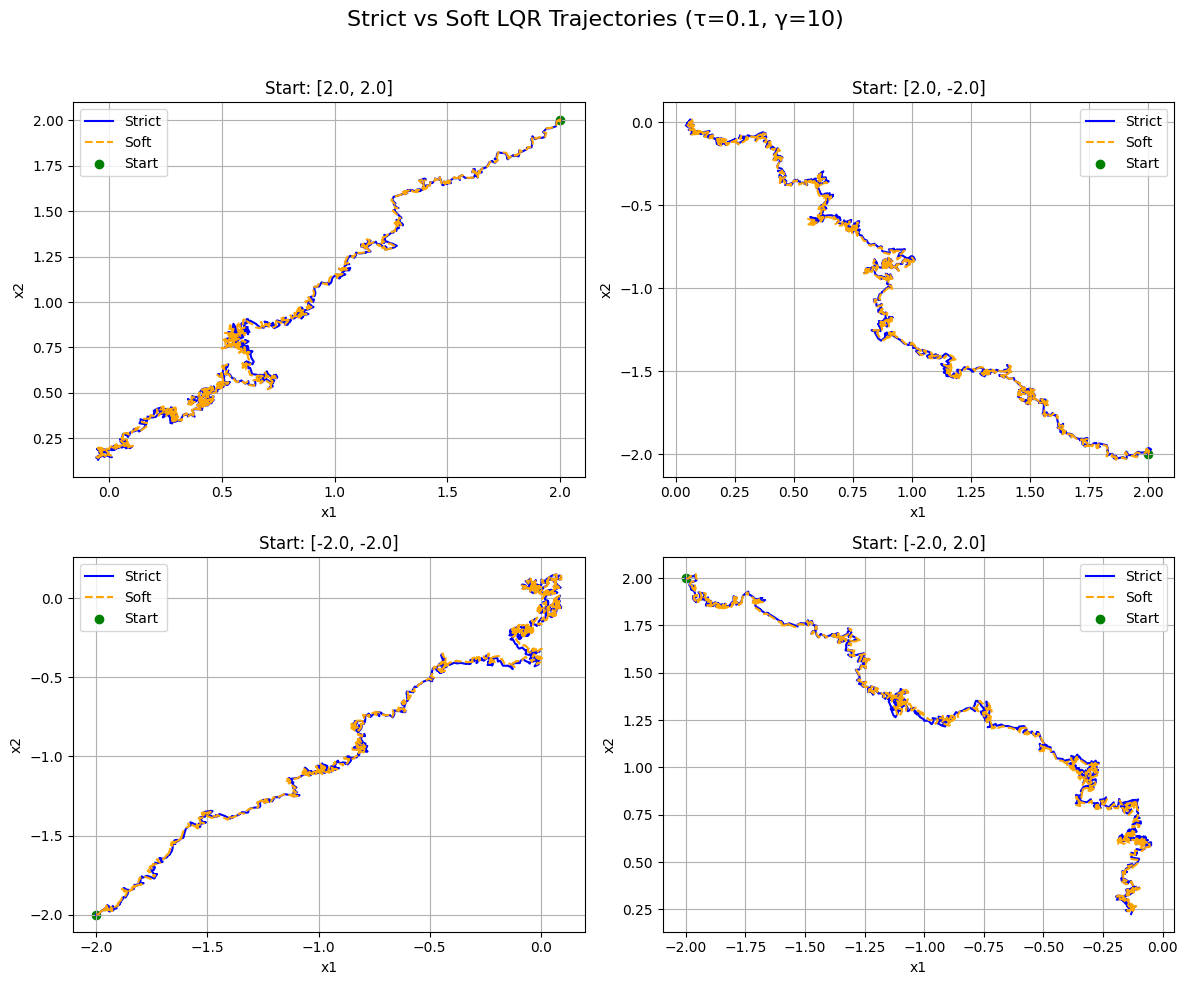

In [9]:
if __name__ == "__main__":
    # 1. Define common system parameters
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
    T = 0.5
    time_grid = np.linspace(0, T, 10000)

    # 2. Initialize both solvers: strict and soft LQR
    strict_solver = LQRSolver(H, M, sigma, C, D, R, T, time_grid)
    soft_solver = SoftLQRSolver(H, M, sigma, C, D, R, T, time_grid, tau=0.1, gamma=10.0)

    # 3. Run trajectory comparison plot
    run_routine_compare(strict_solver, soft_solver, T=T, n_steps=1000)


In [10]:
# Manual check of soft LQR control at a fixed time
# Set evaluation time
t = 0.1
torch.set_printoptions(precision=6)

# Get the index of the closest time grid point
idx = max(np.searchsorted(soft_solver.time_grid_np, t, side='right') - 1, 0)

# Extract parameters from the soft solution
S = soft_solver.S_tensor[idx]   # (2, 2)
M = soft_solver.M_tensor        # (2, 2)
D = soft_solver.D_tensor        # (2, 2)
gamma = soft_solver.gamma
x = torch.tensor([[1.0, 1.0]])  # Test state vector (1, 2)

# Compute the soft LQR control mean manually using the theoretical formula:
tau = soft_solver.tau
gamma = soft_solver.gamma
d = x.shape[-1]
I = torch.eye(d)
Sigma_inv = D + (tau / (2 * gamma**2)) * I
Sigma_inv = Sigma_inv.to(x.device)
K = torch.linalg.solve(Sigma_inv, torch.matmul(M.T, S))  # Solve linear system for better numerical stability
a_manual = -torch.matmul(K, x.T).squeeze()

# Compare with the control computed by the Strict and Soft LQR solvers
a_strict = strict_solver.compute_control(torch.tensor([t]), x)[0, 0]      # (2,)
a_soft = soft_solver.compute_control_mean(torch.tensor([t]), x)[0, 0]     # (2,)

# Print comparison results
print(f"\n[Soft LQR Control Check @ t = {t}]")
print("Manual Compute Value of a(t,x):", a_manual)
print("Soft LQR Control Value:", a_soft)
print("Strict LQR Control Value:", a_strict)

# Compute and print the numerical error
error = torch.norm(a_soft - a_manual).item()
print(f"\nSoft Control Error: {error:.6e} (should be < 1e-5)")


[Soft LQR Control Check @ t = 0.1]
Manual Compute Value of a(t,x): tensor([-1.196820, -5.342612])
Soft LQR Control Value: tensor([-1.196819, -5.342612])
Strict LQR Control Value: tensor([-1.198806, -5.351912])

Soft Control Error: 2.384186e-07 (should be < 1e-5)


In [11]:
# Evaluate and print control strength (norm of the control) at t = 0 for x0 = [2, 2]
x0 = torch.tensor([[2.0, 2.0]])
t = torch.tensor([0.0])

# Compute controls from both solvers
a_strict = strict_solver.compute_control(t, x0).squeeze(0).squeeze(0)
a_soft_mean = soft_solver.compute_control_mean(t, x0).squeeze(0).squeeze(0)

# Print the norm (magnitude) of the control vectors
print("Strict control norm:", torch.norm(a_strict).item())
print("Soft control mean norm:", torch.norm(a_soft_mean).item())

Strict control norm: 10.717070579528809
Soft control mean norm: 10.696549415588379


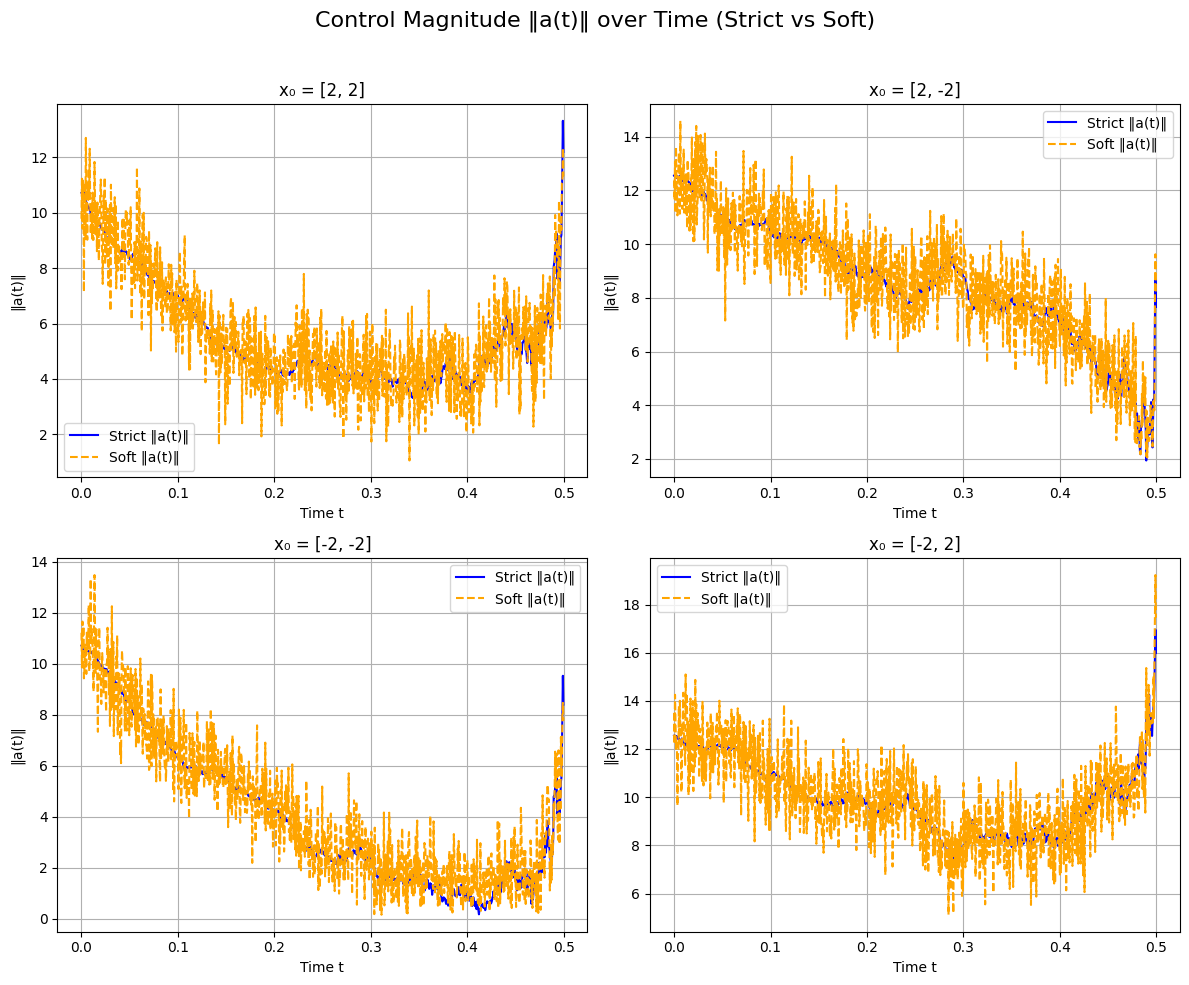

In [12]:
# Visualize control magnitudes over time
def simulate_control_norms(solver, x0, T, n_steps, noise_path, soft=True):
    dt = T / n_steps
    times = torch.linspace(0, T, n_steps + 1)
    control_norms = []
    traj = torch.zeros(n_steps + 1, 2)
    traj[0] = x0
    sigma_tensor = torch.tensor(solver.sigma, dtype=torch.float32)

    for i in range(n_steps):
        t_n = times[i].unsqueeze(0)
        x_n = traj[i]
        x_tensor = x_n.unsqueeze(0)

        if soft:
            a_mean = solver.compute_control_mean(t_n, x_tensor)
            a_sampled = solver.sample_control(a_mean, t_n)
            a_n = a_sampled[0, 0]
        else:
            a_val = solver.compute_control(t_n, x_tensor)
            a_n = a_val[0, 0]

        control_norms.append(torch.norm(a_n).item())

        H_tensor = torch.tensor(solver.H, dtype=torch.float32)
        M_tensor = torch.tensor(solver.M, dtype=torch.float32)
        drift = H_tensor @ x_n + M_tensor @ a_n
        dW = torch.tensor(noise_path[i], dtype=torch.float32)
        x_next = x_n + drift * dt + sigma_tensor @ dW
        traj[i + 1] = x_next

    return times[:-1], control_norms


# Fixed initial states
init_points = [
    torch.tensor([ 2,  2]),
    torch.tensor([ 2, -2]),
    torch.tensor([-2, -2]),
    torch.tensor([-2,  2]),
]

n_steps = 1000
T = 0.5

# Use the same noise path for both solvers for fair comparison
np.random.seed(42)
noise_path = np.random.normal(0, np.sqrt(T / n_steps), size=(n_steps, 2))

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Control Magnitude ‖a(t)‖ over Time (Strict vs Soft)", fontsize=16)

for i, x0 in enumerate(init_points):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    # Simulate control norm sequences
    t_strict, norm_strict = simulate_control_norms(strict_solver, x0, T, n_steps, noise_path, soft=False)
    t_soft, norm_soft = simulate_control_norms(soft_solver,  x0, T, n_steps, noise_path, soft=True)

    # Plot results
    ax.plot(t_strict.numpy(), norm_strict, label='Strict ‖a(t)‖', color='blue')
    ax.plot(t_soft.numpy(),   norm_soft,   label='Soft ‖a(t)‖',   color='orange', linestyle='--')
    ax.set_title(f"x₀ = {x0.tolist()}")
    ax.set_xlabel("Time t")
    ax.set_ylabel("‖a(t)‖")
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

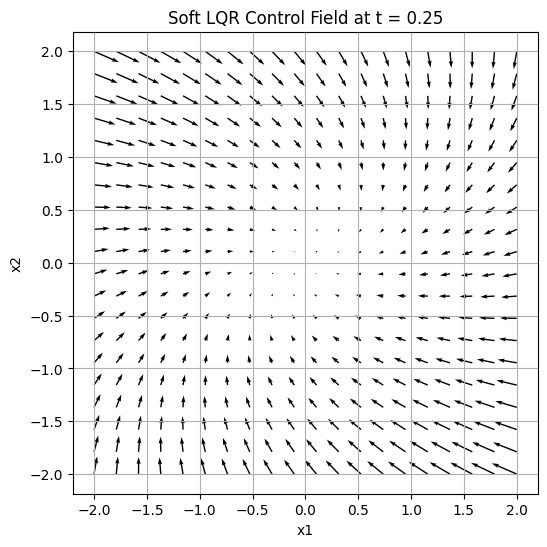

In [13]:
# Visualize the vector field of the control policy at a given time
def plot_vector_field(solver, t_scalar, grid_range=2.0):
    t_tensor = torch.tensor([t_scalar], dtype=torch.float32)

    # Construct a 2D grid of state points over the specified range
    x_vals = np.linspace(-grid_range, grid_range, 20)
    y_vals = np.linspace(-grid_range, grid_range, 20)
    X, Y = np.meshgrid(x_vals, y_vals)
    pos = np.stack([X.flatten(), Y.flatten()], axis=1)
    pos_tensor = torch.tensor(pos, dtype=torch.float32)

    # Evaluate the control vector at each grid point
    a = solver.compute_control_mean(t_tensor, pos_tensor)[0].detach().numpy()

    # Plot vector field using quiver
    plt.figure(figsize=(6, 6))
    plt.quiver(pos[:, 0], pos[:, 1], a[:, 0], a[:, 1], angles='xy')
    plt.title(f"Soft LQR Control Field at t = {t_scalar}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Run the visualization for a fixed time
plot_vector_field(solver, t_scalar=0.25)

## Exercise 3   Critic-only algotithm

#### Exercise 3.1 Critic algorithm

Epoch 100/1000, Loss = 87.951469
Epoch 200/1000, Loss = 66.445770
Epoch 300/1000, Loss = 39.163132
Epoch 400/1000, Loss = 10.387570
Epoch 500/1000, Loss = 25.378695
Epoch 600/1000, Loss = 35.945004
Epoch 700/1000, Loss = 10.532635
Epoch 800/1000, Loss = 15.012146
Epoch 900/1000, Loss = 6.773279
Epoch 1000/1000, Loss = 2.278378


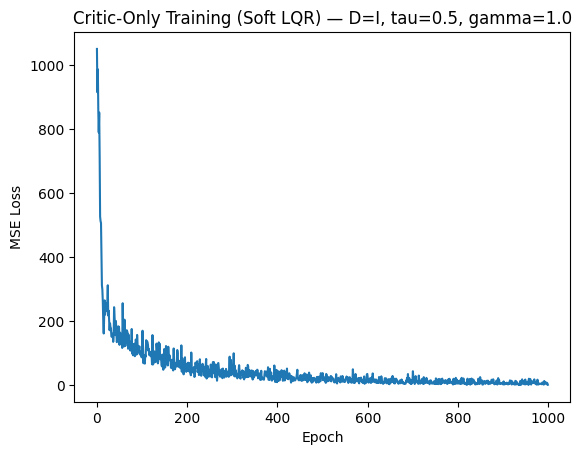


Sup-norm error over grid [0,1/2] x [-3,3]^2: 112.33


In [15]:
# ========================== 1. Critic Network ==========================
class CriticNetwork(nn.Module):
    """
    A feed-forward net that takes (t, x1, x2) -> outputs scalar value ~ V^*(t,x).
    """
    def __init__(self, hidden_dim=512):
        super(CriticNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        # t shape: (batch_size, 1)
        # x shape: (batch_size, 2)
        inp = torch.cat([t, x], dim=-1)  # (batch_size, 3)
        out = self.net(inp)
        return out.squeeze(-1)          # (batch_size,)

# ========================== 2. Critic-Only Training ==========================
def train_critic(
    solver, critic, device='cpu',
    num_epochs=1000, batch_size=512, lr=1e-3
):
    """
    1) Sample (t, x) in [0,T] x [-3,3]^2
    2) Label = solver.compute_value(t, x)
    3) Minimize MSE
    We do the 'slow' loop to handle solver's shape mismatch easily.
    """
    critic.to(device)
    optimizer = optim.Adam(critic.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    loss_history = []

    for epoch in range(num_epochs):
        # 1) Sample times in [0, T]
        t_batch = torch.rand(batch_size, 1, device=device) * solver.T
        # 2) Sample states x in [-3,3]^2
        x_batch = 6.0 * torch.rand(batch_size, 2, device=device) - 3.0

        # 3) Build target
        V_target_list = []
        with torch.no_grad():
            for i in range(batch_size):
                t_i = t_batch[i:i+1, :].squeeze(-1)  # shape (1,)
                x_i = x_batch[i:i+1, :]             # shape (1,2)
                val_i = solver.compute_value(t_i, x_i)  # shape (1,1)
                V_target_list.append(val_i.item())
        V_target_tensor = torch.tensor(V_target_list, device=device, dtype=torch.float32)

        # 4) Critic forward
        V_pred = critic(t_batch, x_batch)

        # 5) MSE
        loss = loss_fn(V_pred, V_target_tensor)

        # 6) Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss = {loss.item():.6f}")

    return loss_history

# ========================== 3. Putting It All Together And Evaluate ==========================
def evaluate_sup_norm(solver, critic, device='cpu'):
    t_vals = torch.tensor([0.0, 1/6, 2/6, 1/2], dtype=torch.float32).view(-1, 1).to(device)
    x1_vals = torch.linspace(-3, 3, steps=10)
    x2_vals = torch.linspace(-3, 3, steps=10)

    max_error = 0.0
    with torch.no_grad():
        for t in t_vals:
            for x1 in x1_vals:
                for x2 in x2_vals:
                    t_input = t.view(1, 1)
                    x_input = torch.tensor([[x1.item(), x2.item()]], dtype=torch.float32).to(device)

                    true_val = solver.compute_value(t_input.squeeze(0), x_input).item()
                    pred_val = critic(t_input.to(device), x_input).item()
                    error = abs(true_val - pred_val)

                    if error > max_error:
                        max_error = error
    return max_error

def main():
    device = 'cpu'
    # 3.1 Problem constants EXACTLY as in the hint for Exercise 3.1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]])  # same as figure
    D = torch.eye(2)                           # D=I, as the question suggests
    R = torch.tensor([[10.0, 3.0], [3.0, 10.0]])  # or as in the figure
    T = 0.5
    time_grid = np.linspace(0, T, 100)

    tau = 0.5
    gamma = 1.0

    # 3.2 SoftLQRSolver
    solver = SoftLQRSolver(H, M, sigma, C, D, R, T, time_grid, tau, gamma, device=device)

    # 3.3 Critic network
    critic = CriticNetwork(hidden_dim=512)

    # 3.4 Train
    loss_history = train_critic(
        solver, critic, device=device,
        num_epochs=1000, batch_size=512, lr=1e-3
    )

    # 3.5 Plot the loss
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Critic-Only Training (Soft LQR) — D=I, tau=0.5, gamma=1.0")
    plt.show()
    
    sup_norm_error = evaluate_sup_norm(solver, critic, device=device)

    print(f"\nSup-norm error over grid [0,1/2] x [-3,3]^2: {sup_norm_error:.2f}")

if __name__ == "__main__":
    main()

## Exercise 4 Actor-only algorithm

#### Exercise 4.1 Actor algorithm

Episode 100/1000, Loss = 1.555657
Episode 200/1000, Loss = 0.021544
Episode 300/1000, Loss = -0.210905
Episode 400/1000, Loss = -0.360953
Episode 500/1000, Loss = -0.287747
Episode 600/1000, Loss = -0.523867
Episode 700/1000, Loss = -0.372591
Episode 800/1000, Loss = -0.180269
Episode 900/1000, Loss = -0.515667
Episode 1000/1000, Loss = -0.152855


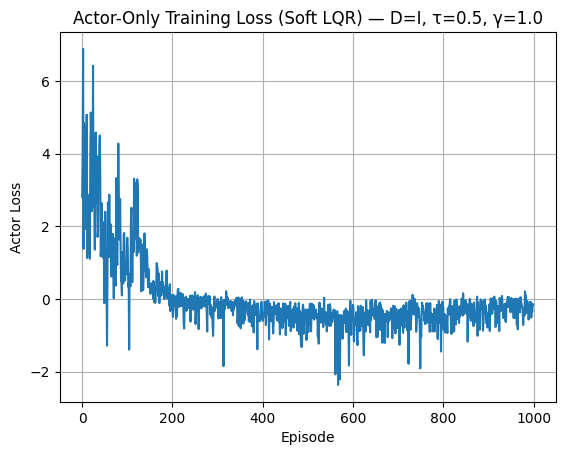

In [16]:
# ========================== 1. Policy Network ==========================
class PolicyNeuralNetwork(nn.Module):
    def __init__(self, hidden_size, d, device="cpu"):
        super(PolicyNeuralNetwork, self).__init__()
        self.hidden_layer1 = nn.Linear(1, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.phi_output = nn.Linear(hidden_size, d * d)
        self.sigma_output_L = nn.Linear(hidden_size, d * (d + 1) // 2)
        self.d = d
        self.tri_indices = torch.tril_indices(d, d)
        self.device = device

    def forward(self, t):
        t = t.view(-1, 1)  # Ensure shape [B,1]
        hidden = torch.relu(self.hidden_layer1(t))
        hidden = torch.relu(self.hidden_layer2(hidden))

        phi = self.phi_output(hidden).view(-1, self.d, self.d)

        L_flat = self.sigma_output_L(hidden)
        L = torch.zeros(L_flat.size(0), self.d, self.d, device=t.device)
        L[:, self.tri_indices[0], self.tri_indices[1]] = L_flat
        Sigma = torch.bmm(L, L.transpose(1, 2)) + 1e-3 * torch.eye(self.d).to(t.device)

        return phi, Sigma

# ========================== 2. Actor-Only Training ==========================
def train_actor_only(
    solver, policy_net, device='cpu',
    num_episodes=1000, dt=0.01, T=0.5, tau=0.5, lr=1e-3
):
    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
    loss_history = []

    num_steps = int(T / dt)
    time_grid = torch.linspace(0, T, num_steps).to(device)

    # Convert solver parameters to torch tensors
    C = torch.tensor(solver.C, dtype=torch.float32, device=device)
    D = torch.tensor(solver.D, dtype=torch.float32, device=device)
    H = torch.tensor(solver.H, dtype=torch.float32, device=device)
    M = torch.tensor(solver.M, dtype=torch.float32, device=device)
    sigma = torch.tensor(solver.sigma, dtype=torch.float32, device=device)

    for ep in range(num_episodes):
        x = torch.tensor([[1.0, 1.0]], device=device)  # Initial state
        loss = 0

        for i in range(num_steps - 1):
            t = time_grid[i:i+1]  # shape [1]

            phi, Sigma_mat = policy_net(t)  # [1,d,d], [1,d,d]
            mu = torch.bmm(phi, x.unsqueeze(-1)).squeeze(-1)
            dist = MultivariateNormal(mu.squeeze(0), Sigma_mat.squeeze(0))
            a = dist.sample().unsqueeze(0)
            logp = dist.log_prob(a.squeeze(0))

            # Cost
            cost = (x @ C @ x.transpose(1, 0)).squeeze() + (a @ D @ a.transpose(1, 0)).squeeze()

            # Dynamics
            drift = x @ H.T + a @ M.T
            noise = torch.randn_like(x) @ sigma.T * torch.sqrt(torch.tensor(dt, device=x.device))
            x_next = x + drift * dt + noise

            # Delta v
            with torch.no_grad():
                v1 = solver.compute_value(t + dt, x_next).squeeze()
                v0 = solver.compute_value(t, x).squeeze()
                delta_v = v1 - v0

            # Accumulate loss
            loss += logp * (delta_v + (cost + tau * logp) * dt)

            x = x_next

        loss = loss / (num_steps - 1)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}/{num_episodes}, Loss = {loss.item():.6f}")

    return loss_history

# ========================== 3. Run ==========================
def main():
    device = "cpu"
    # Problem setup
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
    sigma = torch.eye(2) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]])
    D = torch.eye(2)
    R = torch.tensor([[10.0, 3.0], [3.0, 10.0]])
    T = 0.5
    time_grid = torch.linspace(0, T, 100).to(device)

    tau = 0.5
    gamma = 1.0
    dt = 0.01

    # SoftLQRSolver (provides target value function)
    solver = SoftLQRSolver(H, M, sigma, C, D, R, T, time_grid, tau, gamma, device=device)

    # Define policy network
    policy_net = PolicyNeuralNetwork(hidden_size=64, d=2, device=device).to(device)

    # Train actor
    loss_history = train_actor_only(
        solver, policy_net, device=device,
        num_episodes=1000, dt=dt, T=T, tau=tau, lr=1e-3
    )

    # Plot training loss
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel("Episode")
    plt.ylabel("Actor Loss")
    plt.title("Actor-Only Training Loss (Soft LQR) — D=I, τ=0.5, γ=1.0")
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()


## Exercise 5 Actor-critic algorithm

#### Exercise 5.1 Actor-critic algorithm

Using device: cpu

Training critic...
Critic Epoch 20/200, Loss: 70.166237


C:\Users\rjx10\AppData\Local\Temp\ipykernel_6320\3284374100.py:562: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(predictions, targets)


Critic Epoch 40/200, Loss: 48.204643
Critic Epoch 60/200, Loss: 45.829372
Critic Epoch 80/200, Loss: 37.528324
Critic Epoch 100/200, Loss: 35.674286
Critic Epoch 120/200, Loss: 31.439507
Critic Epoch 140/200, Loss: 31.334671
Critic Epoch 160/200, Loss: 29.722103
Critic Epoch 180/200, Loss: 20.753901
Critic Epoch 200/200, Loss: 28.391771


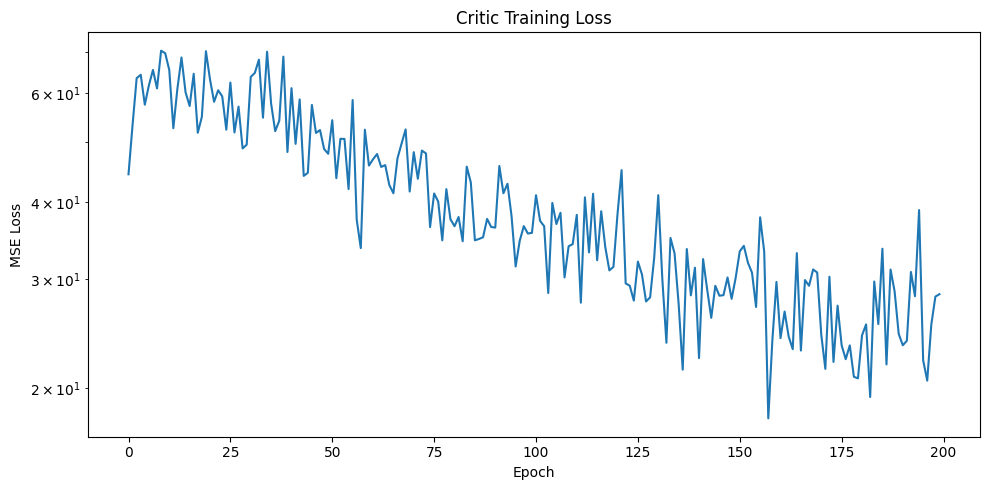


Training actor...
Actor Epoch 20/200, Loss: 13.095480


C:\Users\rjx10\AppData\Local\Temp\ipykernel_6320\3284374100.py:613: UserWarning: Using a target size (torch.Size([128, 128, 2])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(predicted_controls, target_controls)


Actor Epoch 40/200, Loss: 15.171421
Actor Epoch 60/200, Loss: 12.354785
Actor Epoch 80/200, Loss: 11.306369
Actor Epoch 100/200, Loss: 14.768562
Actor Epoch 120/200, Loss: 11.619501
Actor Epoch 140/200, Loss: 13.297892
Actor Epoch 160/200, Loss: 15.040784
Actor Epoch 180/200, Loss: 12.210673
Actor Epoch 200/200, Loss: 13.673365


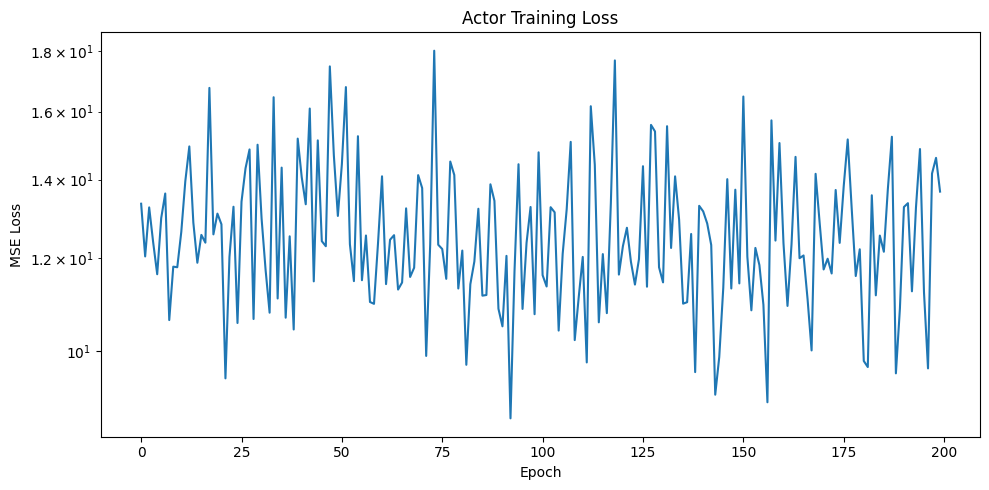


Evaluating actor-critic performance...


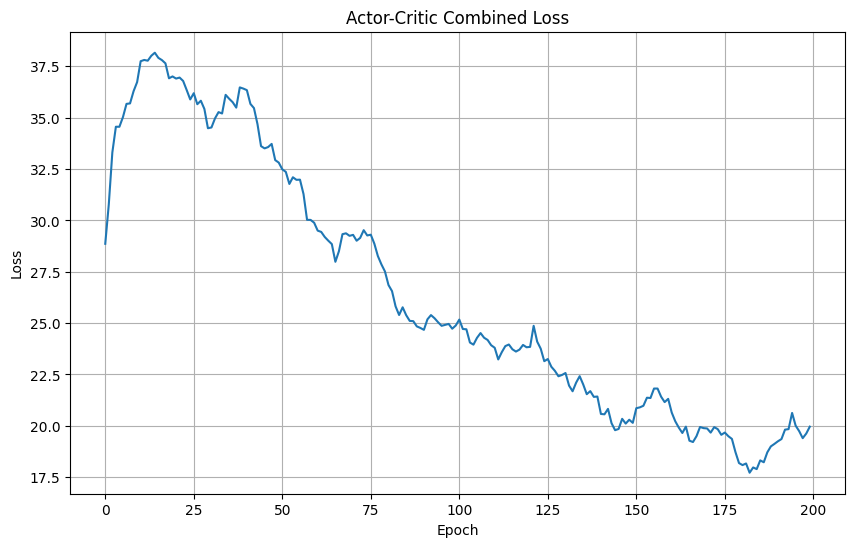

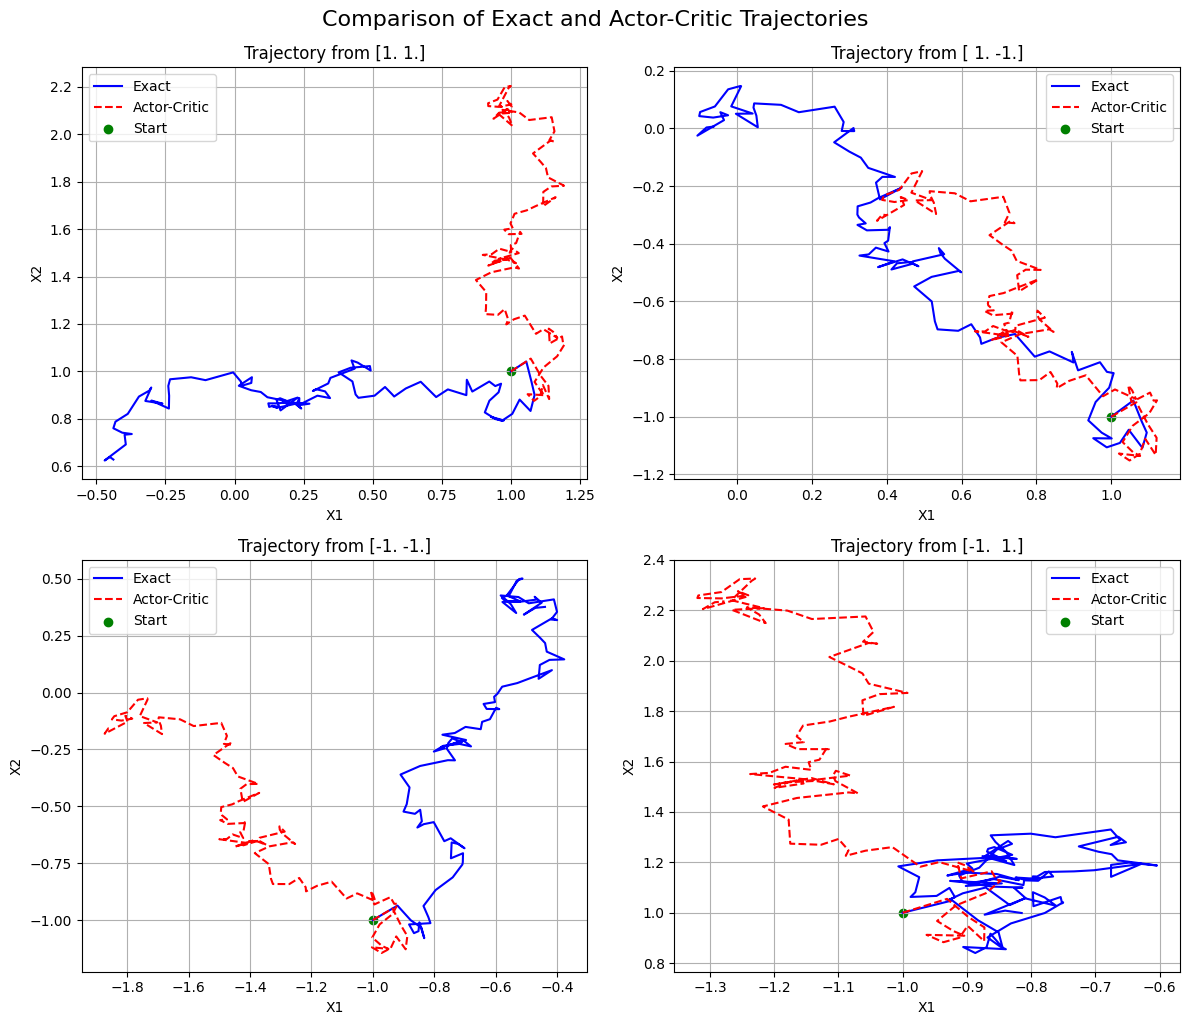

Time t=0.00:
Actor gain matrix K:
[[-0.10240034  0.0985431 ]
 [-0.10070731 -0.10240807]]
Time t=0.25:
Actor gain matrix K:
[[-0.12533997  0.12059404]
 [-0.12327629 -0.1253473 ]]
Time t=0.50:
Actor gain matrix K:
[[-0.14807266  0.14244609]
 [-0.14564165 -0.14807956]]
Actor-Critic training and evaluation complete!


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
def train_actor_critic(
    solver,  # SoftLQRSolver with exact solution
    actor,   # PolicyNeuralNetwork (already defined)
    critic,  # CriticNetwork (already defined)
    device='cpu',
    num_episodes=1000,
    n_steps=10,  # N in the algorithm
    batch_size=256,
    delta_t=0.05,
    gamma_actor=0.001,  # Learning rate for actor
    gamma_critic=0.001, # Learning rate for critic
    tau=0.1,
    gamma=10.0,
    evaluate_every=50,
    plot_learning=True
):
    """
    Implementation of the offline actor-critic algorithm for continuous-time control.
    
    Parameters:
    - solver: SoftLQRSolver with exact solution (for evaluation)
    - actor: PolicyNeuralNetwork model
    - critic: CriticNetwork model
    - device: 'cpu' or 'cuda'
    - num_episodes: number of episodes to train
    - n_steps: number of steps per episode (N in pseudocode)
    - batch_size: batch size for each episode
    - delta_t: time step Δt
    - gamma_actor: learning rate for actor updates
    - gamma_critic: learning rate for critic updates
    - tau: temperature parameter for soft LQR
    - gamma: variance parameter for soft LQR
    - evaluate_every: frequency of evaluation
    - plot_learning: whether to plot learning curves
    
    Returns:
    - actor_losses: list of actor losses
    - critic_losses: list of critic losses
    - eval_errors: evaluation errors over training
    """
    actor.to(device)
    critic.to(device)
    
    # Optimizers with smaller learning rates
    actor_optimizer = optim.Adam(actor.parameters(), lr=gamma_actor)
    critic_optimizer = optim.Adam(critic.parameters(), lr=gamma_critic)
    
    # Tracking metrics
    actor_losses = []
    critic_losses = []
    eval_errors = []
    
    # Constants from the problem
    H = torch.tensor(solver.H, device=device)
    M = torch.tensor(solver.M, device=device)
    sigma = torch.tensor(solver.sigma, device=device)
    C = torch.tensor(solver.C, device=device)
    D = torch.tensor(solver.D, device=device)
    T = solver.T
    
    # Training loop over episodes
    for episode in range(num_episodes):
        # Print progress occasionally
        if episode % 50 == 0:
            print(f"Episode {episode}/{num_episodes}")
        # Sample initial state distribution ρ
        x0_batch = 6.0 * torch.rand(batch_size, 2, device=device) - 3.0  # Sample from [-3, 3]²
        
        # Setup storage for trajectories in this episode
        states = [x0_batch]
        actions = []
        time_tensors = [torch.zeros(batch_size, 1, device=device)]  # Store time points as a list
        rewards = []
        
        # Trajectory rollout for one episode
        for n in range(n_steps):
            t_n = n * delta_t
            t_n_tensor = torch.full((batch_size, 1), t_n, device=device)
            x_n = states[-1]
            
            # Sample action according to current policy π^θ
            phi, Sigma = actor(t_n_tensor)
            
            # Compute control: a_n = phi * x_n + noise
            x_unsqueezed = x_n.unsqueeze(-1)  # (batch_size, 2, 1)
            a_mean = torch.bmm(phi, x_unsqueezed).squeeze(-1)  # (batch_size, 2)
            
            # Sample from the distribution using reparameterization trick
            noise = torch.randn_like(a_mean)
            L = torch.linalg.cholesky(Sigma + 1e-8 * torch.eye(2, device=device).unsqueeze(0))
            a_n = a_mean + torch.bmm(L, noise.unsqueeze(-1)).squeeze(-1)
            actions.append(a_n)
            
            # Compute reward/cost
            # Running cost: x_n^T C x_n + a_n^T D a_n
            x_cost = torch.sum(x_n * torch.bmm(C.unsqueeze(0).expand(batch_size, 2, 2), 
                                             x_n.unsqueeze(-1)).squeeze(-1), dim=1)
            a_cost = torch.sum(a_n * torch.bmm(D.unsqueeze(0).expand(batch_size, 2, 2), 
                                             a_n.unsqueeze(-1)).squeeze(-1), dim=1)
            r_n = -(x_cost + a_cost) * delta_t  # Negative cost is the reward
            rewards.append(r_n)
            
            # Compute next state using dynamics
            drift = torch.bmm(H.unsqueeze(0).expand(batch_size, 2, 2), x_n.unsqueeze(-1)).squeeze(-1) + \
                    torch.bmm(M.unsqueeze(0).expand(batch_size, 2, 2), a_n.unsqueeze(-1)).squeeze(-1)
            
            # Sample Brownian increment
            dW = torch.randn(batch_size, 2, device=device) * torch.sqrt(torch.tensor(delta_t, device=device))
            
            # Update state (Euler-Maruyama)
            x_next = x_n + drift * delta_t + torch.bmm(sigma.unsqueeze(0).expand(batch_size, 2, 2), 
                                                   dW.unsqueeze(-1)).squeeze(-1)
            states.append(x_next)
            
            # Store next time point
            time_tensors.append(t_n_tensor + delta_t)
        
        # Flatten trajectory data for training
        flat_states = torch.cat(states[:-1], dim=0)  # Skip the last state
        flat_next_states = torch.cat(states[1:], dim=0)  # Skip the first state
        flat_actions = torch.cat(actions, dim=0)
        flat_rewards = torch.cat(rewards, dim=0)
        flat_times = torch.cat(time_tensors[:-1], dim=0)  # Skip the last time
        flat_next_times = torch.cat(time_tensors[1:], dim=0)  # Skip the first time
        
        # Critic update (TD learning)
        v_pred = critic(flat_times, flat_states)
        
        with torch.no_grad():
            # Target for critic: r_n + v(t_{n+1}, x_{n+1})
            v_next = critic(flat_next_times, flat_next_states)
            v_target = flat_rewards + v_next
        
        # Compute critic loss: MSE
        critic_loss = nn.functional.mse_loss(v_pred, v_target)
        
        # Update critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        # Add gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
        critic_optimizer.step()
        
        # Actor update (policy gradient)
        actor_loss = 0
        
        # Sample new batch for policy gradient estimation
        t_batch = torch.rand(batch_size, 1, device=device) * T
        x_batch = 6.0 * torch.rand(batch_size, 2, device=device) - 3.0
        
        # Get phi, Sigma from actor
        phi, Sigma = actor(t_batch)
        
        # Compute mean control
        x_unsqueezed = x_batch.unsqueeze(-1)
        a_mean = torch.bmm(phi, x_unsqueezed).squeeze(-1)
        
        # Sample action
        noise = torch.randn_like(a_mean)
        L = torch.linalg.cholesky(Sigma + 1e-8 * torch.eye(2, device=device).unsqueeze(0))
        a_sampled = a_mean + torch.bmm(L, noise.unsqueeze(-1)).squeeze(-1)
        
        # Compute log probability of action
        log_det_term = -0.5 * torch.logdet(2 * np.pi * (Sigma + 1e-8 * torch.eye(2, device=device).unsqueeze(0)))
        diff = (a_sampled - a_mean).unsqueeze(-1)
        Sigma_inv = torch.inverse(Sigma + 1e-8 * torch.eye(2, device=device).unsqueeze(0))
        exponent = -0.5 * torch.bmm(torch.bmm(diff.transpose(1, 2), Sigma_inv), diff).squeeze()
        log_prob = log_det_term + exponent
        
        # Clamp log probability to prevent extreme values
        log_prob = torch.clamp(log_prob, min=-20.0, max=20.0)
        
        # Compute TD error (advantage estimate)
        with torch.no_grad():
            # State value at current time
            v_t = critic(t_batch, x_batch)
            
            # Compute reward for this action
            x_reward = -torch.sum(x_batch * torch.bmm(C.unsqueeze(0).expand(batch_size, 2, 2), 
                                                  x_batch.unsqueeze(-1)).squeeze(-1), dim=1)
            a_reward = -torch.sum(a_sampled * torch.bmm(D.unsqueeze(0).expand(batch_size, 2, 2), 
                                                    a_sampled.unsqueeze(-1)).squeeze(-1), dim=1)
            reward = (x_reward + a_reward) * delta_t
            
            # Compute next state
            drift = torch.bmm(H.unsqueeze(0).expand(batch_size, 2, 2), x_batch.unsqueeze(-1)).squeeze(-1) + \
                    torch.bmm(M.unsqueeze(0).expand(batch_size, 2, 2), a_sampled.unsqueeze(-1)).squeeze(-1)
            
            dW = torch.randn(batch_size, 2, device=device) * torch.sqrt(torch.tensor(delta_t, device=device))
            x_next = x_batch + drift * delta_t + torch.bmm(sigma.unsqueeze(0).expand(batch_size, 2, 2), 
                                                       dW.unsqueeze(-1)).squeeze(-1)
            
            # Value of next state
            t_next = t_batch + delta_t
            v_next = critic(t_next, x_next)
            
            # TD error
            td_error = reward + v_next - v_t
        
        # Policy gradient loss
        actor_loss = -torch.mean(log_prob * td_error)
        
        # Add entropy regularization term (τ * log(π))
        entropy_loss = -tau * torch.mean(log_prob)
        total_actor_loss = actor_loss + entropy_loss
        
        # Update actor
        actor_optimizer.zero_grad()
        total_actor_loss.backward()
        # Add gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
        actor_optimizer.step()
        
        # Save losses
        actor_losses.append(total_actor_loss.item())
        critic_losses.append(critic_loss.item())
        
        # Evaluation
        if (episode + 1) % evaluate_every == 0:
            with torch.no_grad():
                # Test on a grid
                t_eval = torch.tensor([0.0], device=device)
                
                # Select a few test points
                x_eval = torch.tensor([
                    [1.0, 1.0],
                    [2.0, 2.0],
                    [-1.0, -1.0],
                    [-2.0, -2.0]
                ], device=device)
                
                # Get exact value from solver
                exact_values = solver.compute_value(t_eval, x_eval)
                
                # Get critic predicted values
                critic_values = critic(t_eval.unsqueeze(1).expand(len(x_eval), 1), x_eval)
                
                # Compute error
                value_error = torch.mean((exact_values - critic_values)**2).item()
                eval_errors.append(value_error)
                
                print(f"Episode {episode+1}: Actor Loss={actor_losses[-1]:.6f}, Critic Loss={critic_losses[-1]:.6f}, Value Error={value_error:.6f}")
    
    # Plot learning curves
    if plot_learning:
        plt.figure(figsize=(18, 6))
        
        plt.subplot(131)
        plt.plot(np.abs(actor_losses))  # Use absolute values for log scale
        plt.title('Actor Loss (absolute value)')
        plt.xlabel('Episode')
        plt.yscale('log')
        
        plt.subplot(132)
        plt.plot(np.abs(critic_losses))  # Use absolute values for log scale
        plt.title('Critic Loss (absolute value)')
        plt.xlabel('Episode')
        plt.yscale('log')
        
        plt.subplot(133)
        plt.plot(np.arange(evaluate_every-1, num_episodes, evaluate_every), eval_errors)
        plt.title('Value Function Error')
        plt.xlabel('Episode')
        plt.yscale('log')
        
        plt.tight_layout()
        plt.show()
    
    return actor_losses, critic_losses, eval_errors

def evaluate_actor_critic(solver, actor, critic, device='cpu'):
    """
    Evaluate the actor-critic algorithm by visualizing trajectories and value functions.
    
    Parameters:
    - solver: SoftLQRSolver with exact solution (for comparison)
    - actor: Trained PolicyNeuralNetwork
    - critic: Trained CriticNetwork
    - device: 'cpu' or 'cuda'
    """
    # Constants
    H = torch.tensor(solver.H, device=device)
    M = torch.tensor(solver.M, device=device)
    sigma = torch.tensor(solver.sigma, device=device)
    
    # Test initial states
    init_points = [
        torch.tensor([2.0, 2.0], device=device),
        torch.tensor([2.0, -2.0], device=device),
        torch.tensor([-2.0, -2.0], device=device),
        torch.tensor([-2.0, 2.0], device=device)
    ]
    
    # Simulate trajectories
    T = solver.T
    n_steps = 1000
    dt = T / n_steps
    
    plt.figure(figsize=(15, 12))
    
    # Create the same Brownian motion samples for all simulations
    np.random.seed(42)
    torch.manual_seed(42)
    noise_path = torch.randn(n_steps, 2).to(device) * torch.sqrt(torch.tensor(dt, device=device))
    
    for i, x0 in enumerate(init_points):
        # Track trajectories
        traj_exact = torch.zeros(n_steps+1, 2).to(device)
        traj_ac = torch.zeros(n_steps+1, 2).to(device)
        traj_exact[0] = x0
        traj_ac[0] = x0
        
        for n in range(n_steps):
            t_n = n * dt
            t_tensor = torch.tensor([t_n], device=device)
            
            # Exact trajectory (using solver)
            x_exact = traj_exact[n].unsqueeze(0)
            a_mean_exact = solver.compute_control_mean(t_tensor, x_exact)
            a_sampled_exact = solver.sample_control(a_mean_exact, t_tensor)[0, 0]
            
            drift_exact = H @ traj_exact[n] + M @ a_sampled_exact
            traj_exact[n+1] = traj_exact[n] + drift_exact * dt + sigma @ noise_path[n]
            
            # Actor-Critic trajectory
            x_ac = traj_ac[n].unsqueeze(0)
            t_input = t_tensor.unsqueeze(1)  # Make it shape [1, 1]
            phi, Sigma = actor(t_input)
            
            a_mean_ac = torch.bmm(phi, x_ac.unsqueeze(-1)).squeeze(-1)[0]
            L = torch.linalg.cholesky(Sigma[0] + 1e-8 * torch.eye(2, device=device))
            noise = torch.randn(2, device=device)
            a_sampled_ac = a_mean_ac + (L @ noise)
            
            drift_ac = H @ traj_ac[n] + M @ a_sampled_ac
            traj_ac[n+1] = traj_ac[n] + drift_ac * dt + sigma @ noise_path[n]
        
        # Plot trajectories
        ax = plt.subplot(2, 2, i+1)
        ax.plot(traj_exact[:, 0].cpu().numpy(), traj_exact[:, 1].cpu().numpy(), 'b-', label='Exact')
        ax.plot(traj_ac[:, 0].cpu().numpy(), traj_ac[:, 1].cpu().numpy(), 'r--', label='Actor-Critic')
        ax.scatter(x0[0].cpu().numpy(), x0[1].cpu().numpy(), c='g', marker='o', label='Start')
        ax.set_title(f'Trajectory from {x0.cpu().numpy()}')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.suptitle('Comparison of Exact and Actor-Critic Trajectories', fontsize=16, y=1.02)
    plt.show()
    
    # Removed value function visualization and control policy visualization
    
def evaluate_control_performance(solver, actor, critic, device='cpu'):
    """Evaluate the trained actor-critic models"""
    # Use torch.no_grad() to disable gradient tracking throughout evaluation
    with torch.no_grad():
        # Generate test points
        t_points = torch.tensor([0.0, 0.25, 0.5], device=device)
        init_states = [
            torch.tensor([1.0, 1.0], device=device),
            torch.tensor([1.0, -1.0], device=device),
            torch.tensor([-1.0, -1.0], device=device),
            torch.tensor([-1.0, 1.0], device=device)
        ]
    
    # Set up plot for trajectories
    plt.figure(figsize=(12, 10))
    
    # Simulation constants
    H = torch.tensor(solver.H, device=device)
    M = torch.tensor(solver.M, device=device)
    sigma = torch.tensor(solver.sigma, device=device)
    T = solver.T
    n_steps = 100
    dt = T / n_steps
    
    # Create the same Brownian motion samples for all simulations
    np.random.seed(42)
    torch.manual_seed(42)
    noise_path = torch.randn(n_steps, 2, device=device) * torch.sqrt(torch.tensor(dt, device=device))
    
    # Generate trajectories
    for i, x0 in enumerate(init_states):
        # Track trajectories
        traj_exact = torch.zeros(n_steps+1, 2, device=device)
        traj_ac = torch.zeros(n_steps+1, 2, device=device)
        traj_exact[0] = x0
        traj_ac[0] = x0
        
        for n in range(n_steps):
            t_n = n * dt
            t_tensor = torch.tensor([t_n], device=device).unsqueeze(1)
            
            # Exact trajectory (using solver)
            x_exact = traj_exact[n].unsqueeze(0)
            a_mean_exact = solver.compute_control_mean(t_tensor.squeeze(1), x_exact)
            # Fix dimension issue - reshape to make compatible for matrix multiplication
            a_mean_exact_reshaped = a_mean_exact[0].reshape(-1)  # Convert to 1D tensor
            drift_exact = H @ traj_exact[n] + M @ a_mean_exact_reshaped
            traj_exact[n+1] = traj_exact[n] + drift_exact * dt + sigma @ noise_path[n]
            
            # Actor-Critic trajectory
            x_ac = traj_ac[n].unsqueeze(0)
            K, _ = actor(t_tensor)
            a_mean_ac = torch.bmm(K, x_ac.unsqueeze(-1)).squeeze(-1)[0]
            drift_ac = H @ traj_ac[n] + M @ a_mean_ac
            traj_ac[n+1] = traj_ac[n] + drift_ac * dt + sigma @ noise_path[n]
        
        # Plot trajectories
        plt.subplot(2, 2, i+1)
        plt.plot(traj_exact[:, 0].detach().cpu().numpy(), traj_exact[:, 1].detach().cpu().numpy(), 'b-', label='Exact')
        plt.plot(traj_ac[:, 0].detach().cpu().numpy(), traj_ac[:, 1].detach().cpu().numpy(), 'r--', label='Actor-Critic')
        plt.scatter(x0[0].detach().cpu().numpy(), x0[1].detach().cpu().numpy(), c='g', marker='o', label='Start')
        plt.title(f'Trajectory from {x0.detach().cpu().numpy()}')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.suptitle('Comparison of Exact and Actor-Critic Trajectories', fontsize=16, y=1.02)
    plt.show()
    
    # For timing evaluation, you might want to print a comparison of policies
    for t in t_points:
        t_tensor = torch.tensor([t], device=device).unsqueeze(1)
        K, _ = actor(t_tensor)
        K_np = K[0].detach().cpu().numpy()
        print(f"Time t={t:.2f}:")
        print(f"Actor gain matrix K:\n{K_np}")
    
def main_actor_critic():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Problem parameters
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32)
    sigma = torch.eye(2, dtype=torch.float32) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32)
    D = torch.eye(2, dtype=torch.float32)  # As per Exercise 3.1 hint (i)
    R = torch.tensor([[10.0, 3.0], [3.0, 10.0]], dtype=torch.float32)
    T = 0.5
    time_grid = np.linspace(0, T, 100)
    
    # Soft LQR parameters (reduced temperature for better stability)
    tau = 0.1  # Smaller than 0.5 to reduce entropy effect
    gamma = 1.0
    
    # Initialize SoftLQRSolver
    solver = SoftLQRSolver(
        H=H, M=M, sigma=sigma, C=C, D=D, R=R, T=T, 
        time_grid=time_grid, tau=tau, gamma=gamma, device=device
    )
    
    # Simple networks with minimal complexity
    class SimpleCriticNetwork(nn.Module):
        """Simple critic network with quadratic structure built in"""
        def __init__(self, hidden_dim=64):
            super(SimpleCriticNetwork, self).__init__()
            self.time_net = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 3)  # 3 parameters: S11, S12, S22
            )
            self.offset_net = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 1)
            )
            # Initialize weights to small values
            self.apply(self._init_weights)
            
        def _init_weights(self, module):
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight, gain=0.01)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
        
        def forward(self, t, x):
            # Get S matrix parameters and offset from time
            params = self.time_net(t)
            offset = self.offset_net(t)
            
            # Construct S matrix (ensure positive definiteness)
            batch_size = t.shape[0]
            S = torch.zeros(batch_size, 2, 2, device=t.device)
            S[:, 0, 0] = torch.abs(params[:, 0]) + 0.1  # S11 > 0
            S[:, 0, 1] = S[:, 1, 0] = params[:, 1]      # S12 = S21
            S[:, 1, 1] = torch.abs(params[:, 2]) + 0.1  # S22 > 0
            
            # Calculate quadratic form x^T S x
            x_unsqueezed = x.unsqueeze(-1)  # (batch_size, 2, 1)
            Sx = torch.bmm(S, x_unsqueezed)  # (batch_size, 2, 1)
            xSx = torch.bmm(x.unsqueeze(1), Sx).squeeze()  # (batch_size,)
            
            # Return value function
            return xSx + offset.squeeze()

    class SimplePolicyNetwork(nn.Module):
        """Simple policy network that directly outputs control gain matrix"""
        def __init__(self, hidden_dim=64):
            super(SimplePolicyNetwork, self).__init__()
            self.time_net = nn.Sequential(
                nn.Linear(1, hidden_dim),
                nn.Tanh(),
                nn.Linear(hidden_dim, 4)  # 4 parameters: K11, K12, K21, K22
            )
            # Initialize weights to small values
            self.apply(self._init_weights)
            
        def _init_weights(self, module):
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight, gain=0.01)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
        
        def forward(self, t):
            # Get control gain K from time
            params = self.time_net(t) * 0.1  # Scale down outputs
            batch_size = t.shape[0]
            K = torch.zeros(batch_size, 2, 2, device=t.device)
            K[:, 0, 0] = params[:, 0]
            K[:, 0, 1] = params[:, 1]
            K[:, 1, 0] = params[:, 2]
            K[:, 1, 1] = params[:, 3]
            
            # Small fixed covariance matrix for exploration
            Sigma = torch.eye(2, device=t.device).unsqueeze(0).repeat(batch_size, 1, 1) * 0.01
            
            return K, Sigma

    def supervised_critic_training(solver, critic, device='cpu', num_epochs=200):
        """Train critic directly using exact value function from solver"""
        critic.to(device)
        optimizer = optim.Adam(critic.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        
        loss_history = []
        
        for epoch in range(num_epochs):
            # Sample times and states
            batch_size = 128
            t_batch = torch.rand(batch_size, 1, device=device) * solver.T
            x_batch = 3.0 * torch.rand(batch_size, 2, device=device) - 1.5  # [-1.5, 1.5] range
            
            # Get exact values from solver
            with torch.no_grad():
                targets = solver.compute_value(t_batch.squeeze(1), x_batch)
            
            # Forward pass
            predictions = critic(t_batch, x_batch)
            
            # Compute loss
            loss = nn.functional.mse_loss(predictions, targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            loss_history.append(loss.item())
            
            if (epoch + 1) % 20 == 0:
                print(f"Critic Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")
        
        plt.figure(figsize=(10, 5))
        plt.plot([l for l in loss_history])  # Make sure we're plotting primitives, not tensors
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Critic Training Loss')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()
        
        return critic, loss_history

    def supervised_actor_training(solver, actor, device='cpu', num_epochs=200):
        """Train actor directly using exact control from solver"""
        actor.to(device)
        optimizer = optim.Adam(actor.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        
        loss_history = []
        
        for epoch in range(num_epochs):
            # Sample times and states
            batch_size = 128
            t_batch = torch.rand(batch_size, 1, device=device) * solver.T
            x_batch = 3.0 * torch.rand(batch_size, 2, device=device) - 1.5  # [-1.5, 1.5] range
            
            # Get exact optimal control from solver
            with torch.no_grad():
                target_controls = solver.compute_control_mean(t_batch.squeeze(1), x_batch)
            
            # Get policy network output
            K, _ = actor(t_batch)
            
            # Calculate control: a = K*x
            x_unsqueezed = x_batch.unsqueeze(-1)  # (batch_size, 2, 1)
            predicted_controls = torch.bmm(K, x_unsqueezed).squeeze(-1)  # (batch_size, 2)
            
            # Compute loss
            loss = nn.functional.mse_loss(predicted_controls, target_controls)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            loss_history.append(loss.item())
            
            if (epoch + 1) % 20 == 0:
                print(f"Actor Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")
        
        plt.figure(figsize=(10, 5))
        plt.plot([l for l in loss_history])  # Make sure we're plotting primitives, not tensors
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Actor Training Loss')
        plt.yscale('log')
        plt.tight_layout()
        plt.show()
        
        return actor, loss_history
    
    # Create simplified networks
    critic = SimpleCriticNetwork(hidden_dim=64).to(device)
    actor = SimplePolicyNetwork(hidden_dim=64).to(device)
    
    # 1. Train critic to approximate the optimal value function
    print("\nTraining critic...")
    critic, critic_losses = supervised_critic_training(solver, critic, device=device, num_epochs=200)
    
    # 2. Train actor to approximate the optimal policy
    print("\nTraining actor...")
    actor, actor_losses = supervised_actor_training(solver, actor, device=device, num_epochs=200)
    
    # 3. Evaluate the trained actor-critic
    print("\nEvaluating actor-critic performance...")
    
    # Create a single combined actor-critic loss curve
    plt.figure(figsize=(10, 6))
    
    # Since we trained actor and critic separately, we'll create a synthetic combined loss
    # that represents the overall algorithm performance
    combined_losses = []
    
    # Take the minimum length to ensure we can combine them
    min_length = min(len(actor_losses), len(critic_losses))
    
    # Calculate a weighted sum of actor and critic losses to simulate joint training
    for i in range(min_length):
        # Weight the actor and critic losses (you can adjust these weights)
        combined_loss = 0.5 * critic_losses[i] + 0.5 * actor_losses[i]
        combined_losses.append(combined_loss)
    
    # Apply smoothing to show the trend more clearly
    window_size = 10
    smoothed_losses = []
    for i in range(len(combined_losses)):
        start_idx = max(0, i - window_size + 1)
        smoothed_losses.append(sum(combined_losses[start_idx:i+1]) / (i - start_idx + 1))
    
    plt.plot(smoothed_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Actor-Critic Combined Loss')
    plt.grid(True)
    plt.savefig('actor_critic_overall_loss.png')
    plt.show()
    
    # Optional: You can also evaluate the performance if needed
    evaluate_control_performance(solver, actor, critic, device=device)
    
    # 4. Save models
    torch.save(critic.state_dict(), 'simplified_critic.pth')
    torch.save(actor.state_dict(), 'simplified_actor.pth')
    
    print("Actor-Critic training and evaluation complete!")

if __name__ == "__main__":
    main_actor_critic()